In [1]:
using Arpack
using LinearAlgebra
using CairoMakie
using LaTeXStrings
using Revise
using Interpolations
using Roots
using ColorSchemes
using Colors
using QuadGK
using Integrals
using StaticArrays
using BenchmarkTools
using Profile
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/Spinors/rmg_K.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/Lattice_setup/lattice_BZ.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/patch_methods.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/rmg_3pV.jl")

In [937]:
function mBZ_berry(pd, Nl, nu, kappa, V, shells)
    spacing = 10^(-3) * (kappa / pd)
    fig = Figure(size=(2500, 1500), fontsize=50, fonts = (; regular = "italic", weird = "bold"))
    ax1 = Axis(fig[1, 1], title = L"\Omega \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")
    ax2 = Axis(fig[1, 3], title = L"\Omega \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")

    # grid = make_hex([0, 0], kappa, kappa / pd)

    k_list = range(-2*kappa, 2*kappa, 10^2)
    grid = mesh_grid(k_list, k_list, Float64)
    
    bc_list = rmg_full_mBZ_bc(grid, spacing, Nl, nu, kappa, V)

    bc_list2 = rmg_mBZ_shells_bc(grid, spacing, Nl, nu, kappa, V, shells)

    # bc_list = rmg_spinor_bc(grid, spacing, Nl, nu)

    zmax, zmin = maximum(bc_list), minimum(bc_list)

    zabs = maximum([abs(zmax), abs(zmin)])

    levels = range(-zabs, zabs, 10)


    tr1 = tricontourf!(ax1, grid[:, 1], grid[:, 2], bc_list, colormap = :RdBu, levels = levels)
    cb1 = Colorbar(fig[1, 2], tr1)

    zmax, zmin = maximum(bc_list2), minimum(bc_list2)

    zabs = maximum([abs(zmax), abs(zmin)])

    levels = range(-zabs, zabs, 10)

    tr2 = tricontourf!(ax2, grid[:, 1], grid[:, 2], bc_list2, colormap = :RdBu, levels = levels)
    cb2 = Colorbar(fig[1, 4], tr2)
    fig
end

mBZ_berry (generic function with 2 methods)

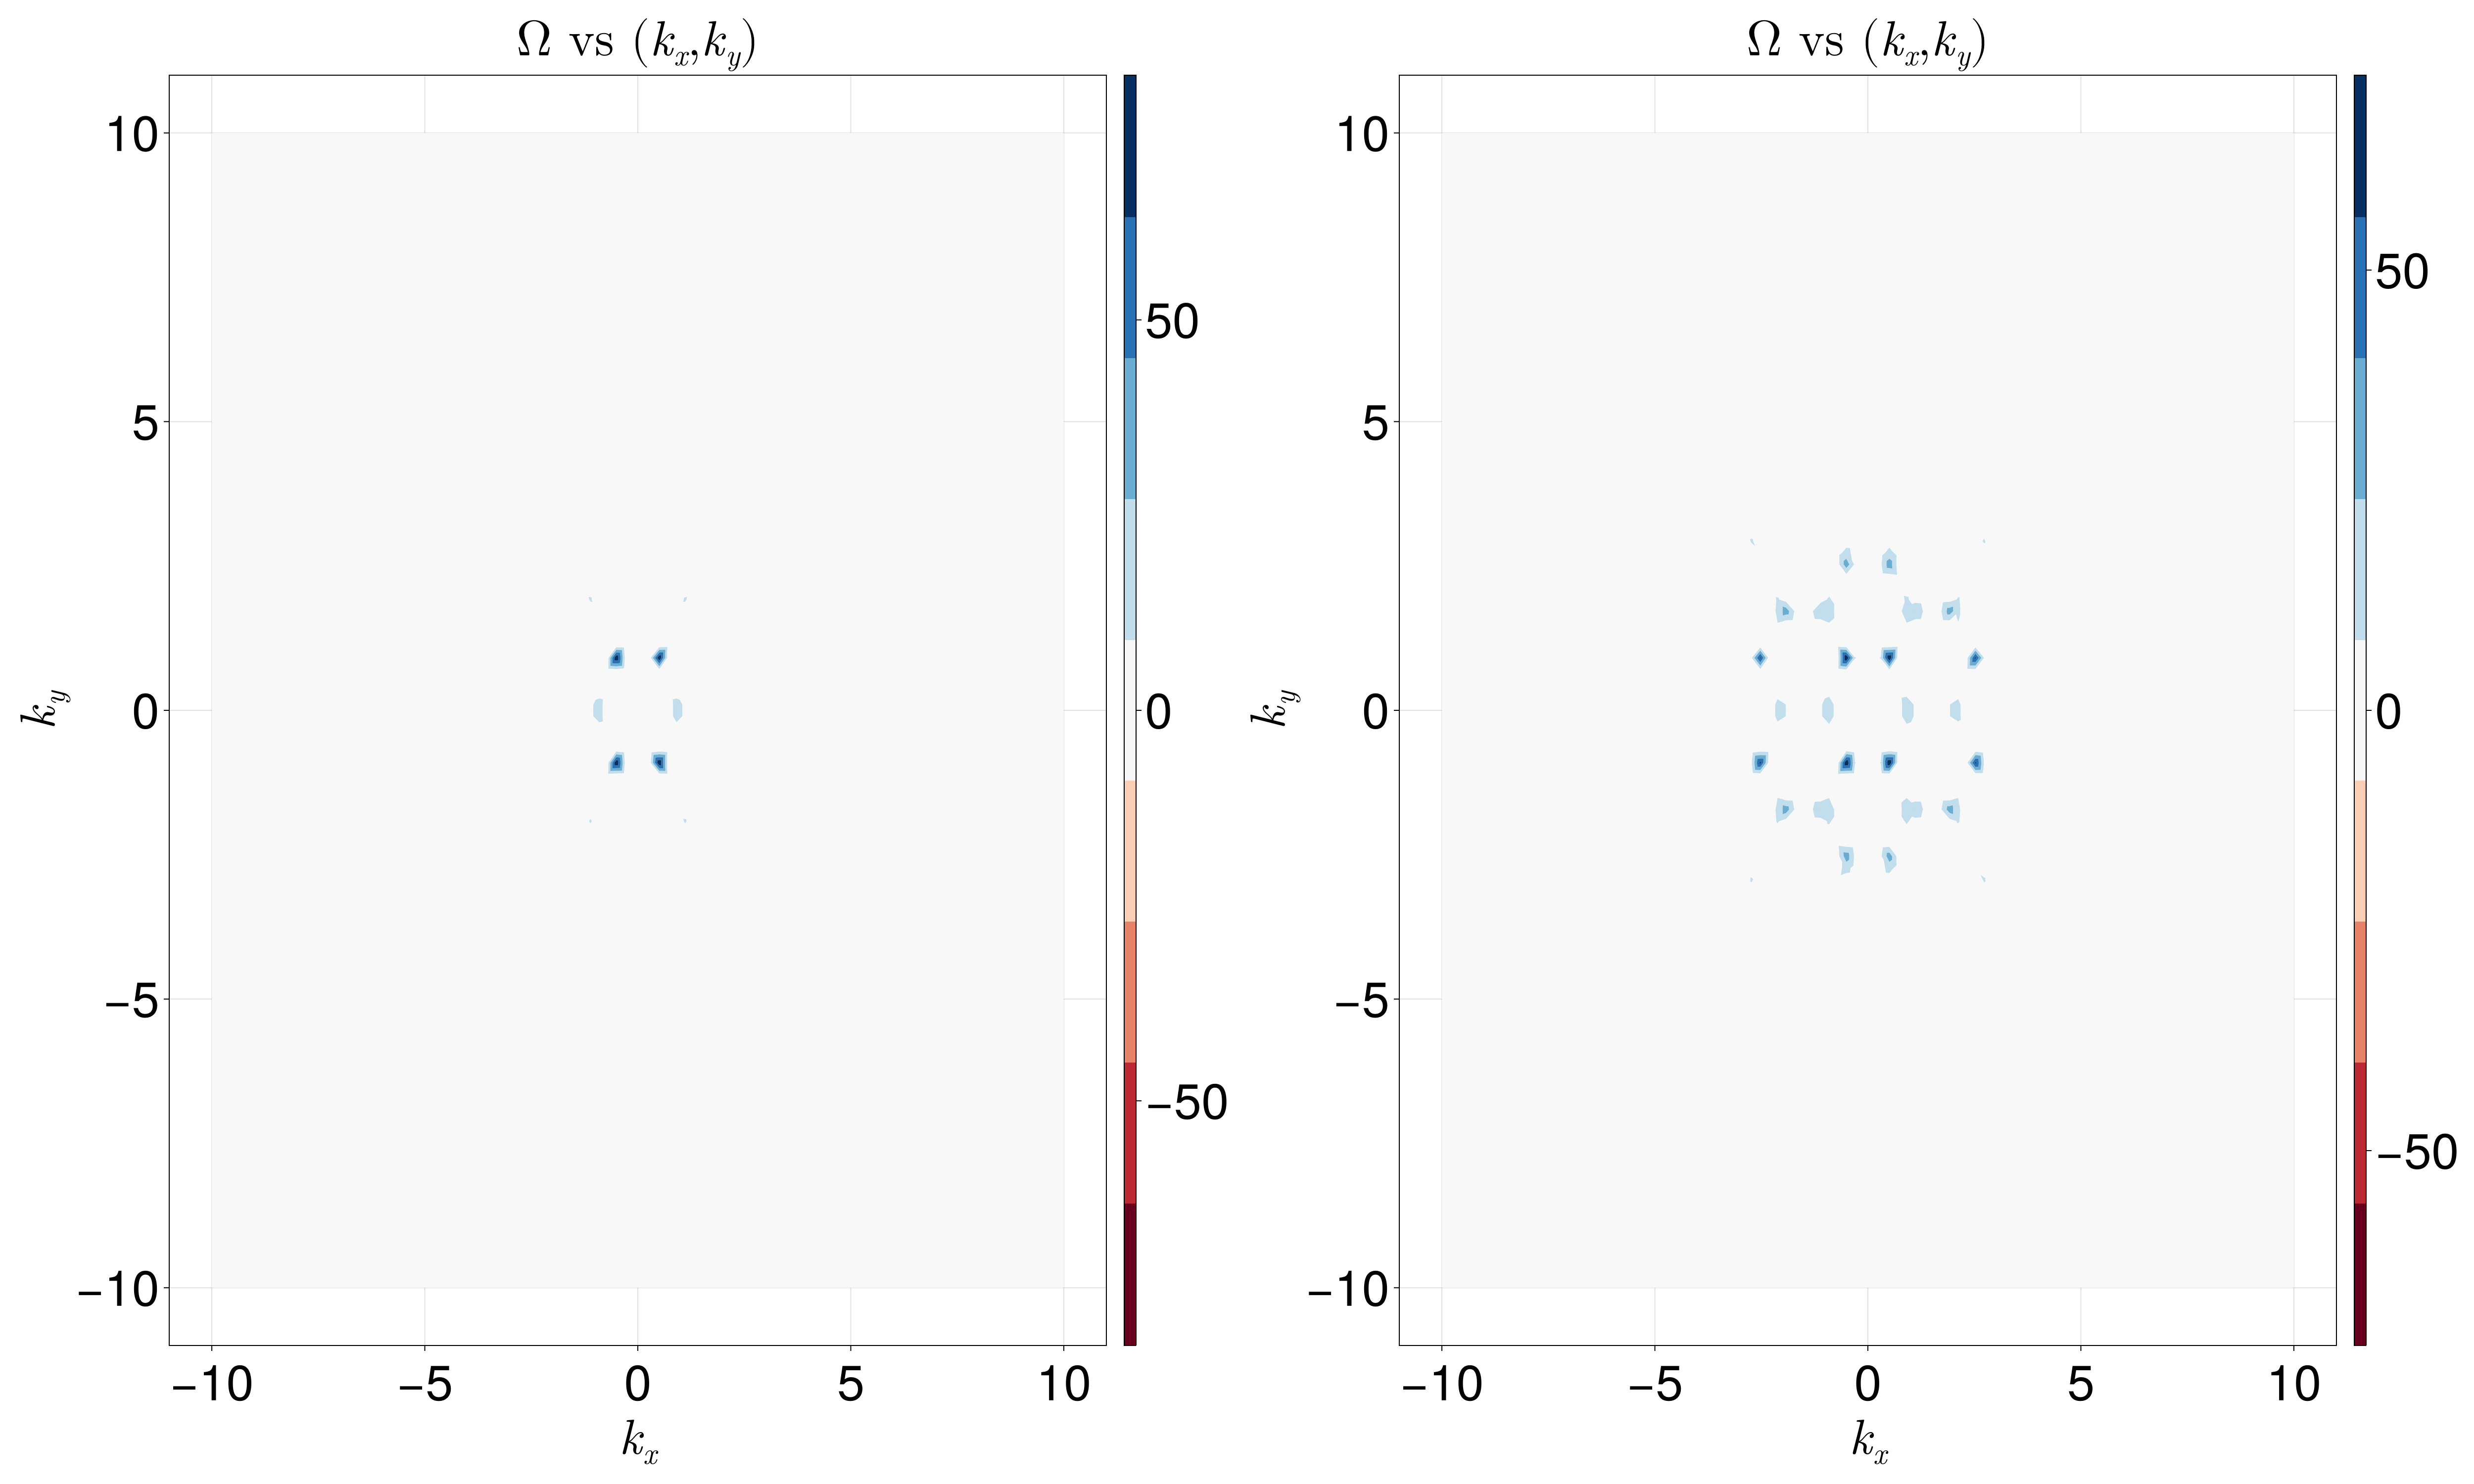

In [919]:
pd = 100
Nl = 3
nu = 0.6
kappa = 1
V = 1
index = 1
mBZ_berry(pd, Nl, nu, kappa, V)

# Animation

In [4]:
# Create grid
pd = 100
Nl = 3
nu = 0.5
kappa = 1
spacing = 10^(-3) * (kappa / pd)
# grid = make_hex([0, 0], kappa, kappa / pd)
k_list = range(-kappa, kappa, 10^2)
# Δ values to animate over
V_list = range(-10, 10, 100)

grid = mesh_grid(k_list, k_list, Float64)
# phis = range(0, 3, 10^2)

# Set up the figure and axis
fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"k_x", ylabel=L"k_y", title="")

ax_super = Axis(fig[:, :], title = L"\Omega(k_x, k_y) \text{ vs } (k_x, k_y) \ | \nu = 0.5", 
titlegap = 50)
hidedecorations!(ax_super, label = false)
hidespines!(ax_super)

bar_list = []
record(fig, "full_mBZ_anim.mp4", V_list) do V
    if length(bar_list) > 0
        delete!(bar_list[end])
    end
    empty!(ax)  # Clear previous frame

    # Evaluate Z on the grid
    Z = rmg_full_mBZ_bc(grid, spacing, Nl, nu, kappa, V)

    # Plot surface
    tr1 = contourf!(ax, grid[:, 1], grid[:, 2], Z, colormap = :RdBu)
    cb1 = Colorbar(fig[1, 2], tr1)
    push!(bar_list, cb1)

    # Update the title
    ax.title = "V = $(round(V, digits=3))"
end


"full_mBZ_anim.mp4"

# Comparison against 3-patch Berry Curvature

In [8]:
function compare_origin_V(spacing, kappa, nu, Nl)
    origin = [0.0, 0.0]
    kappa_1 = kappa * [1, 0.0]
    q = [0.01, 0.01]
    V_list = range(1, 5, 10^2)
    full_mBZ_list = Array{Float64}(undef, length(V_list))
    patch_list = Array{Float64}(undef, length(V_list))
    for j in 1:length(V_list)
        V = V_list[j]
        full_mBZ_list[j] = rmg_full_mBZ_bc(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, V)[1]
        
        delta = V/2 * rmg_delta_all(kappa, nu, Nl)
        alpha = V/2 * rmg_alpha_all(kappa, nu, Nl)
        vF = 3 * kappa^2
        # patch_list[j] = rmg_full_mBZ_bc(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, 0.000000001)[1]
        patch_list[j] = rmg_patch_bc(reshape(origin + q, (1, 2)), spacing, Nl, nu, kappa, vF, delta, alpha)[1]
    end
    P = Figure(size=(1000, 500))
    ax1 = Axis(P[1, 1], xlabel = L"V", ylabel = L"\Omega")
    lines!(ax1, V_list, full_mBZ_list, label = "Full mBZ")
    lines!(ax1, V_list, patch_list, label = "Patch")

    ax2 = Axis(P[1, 3], xlabel = L"V", ylabel = L"\delta \Omega")
    lines!(ax2, V_list, abs.((full_mBZ_list - patch_list)./full_mBZ_list))

    # ax2 = Axis(P[1, 2], xlabel = L"V", 
    # ylabel = L"\delta \Omega")
    # lines!(ax2, V_list, full_mBZ_list ./ patch_list)

    P[1, 2] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)
    P
end

compare_origin_V (generic function with 1 method)

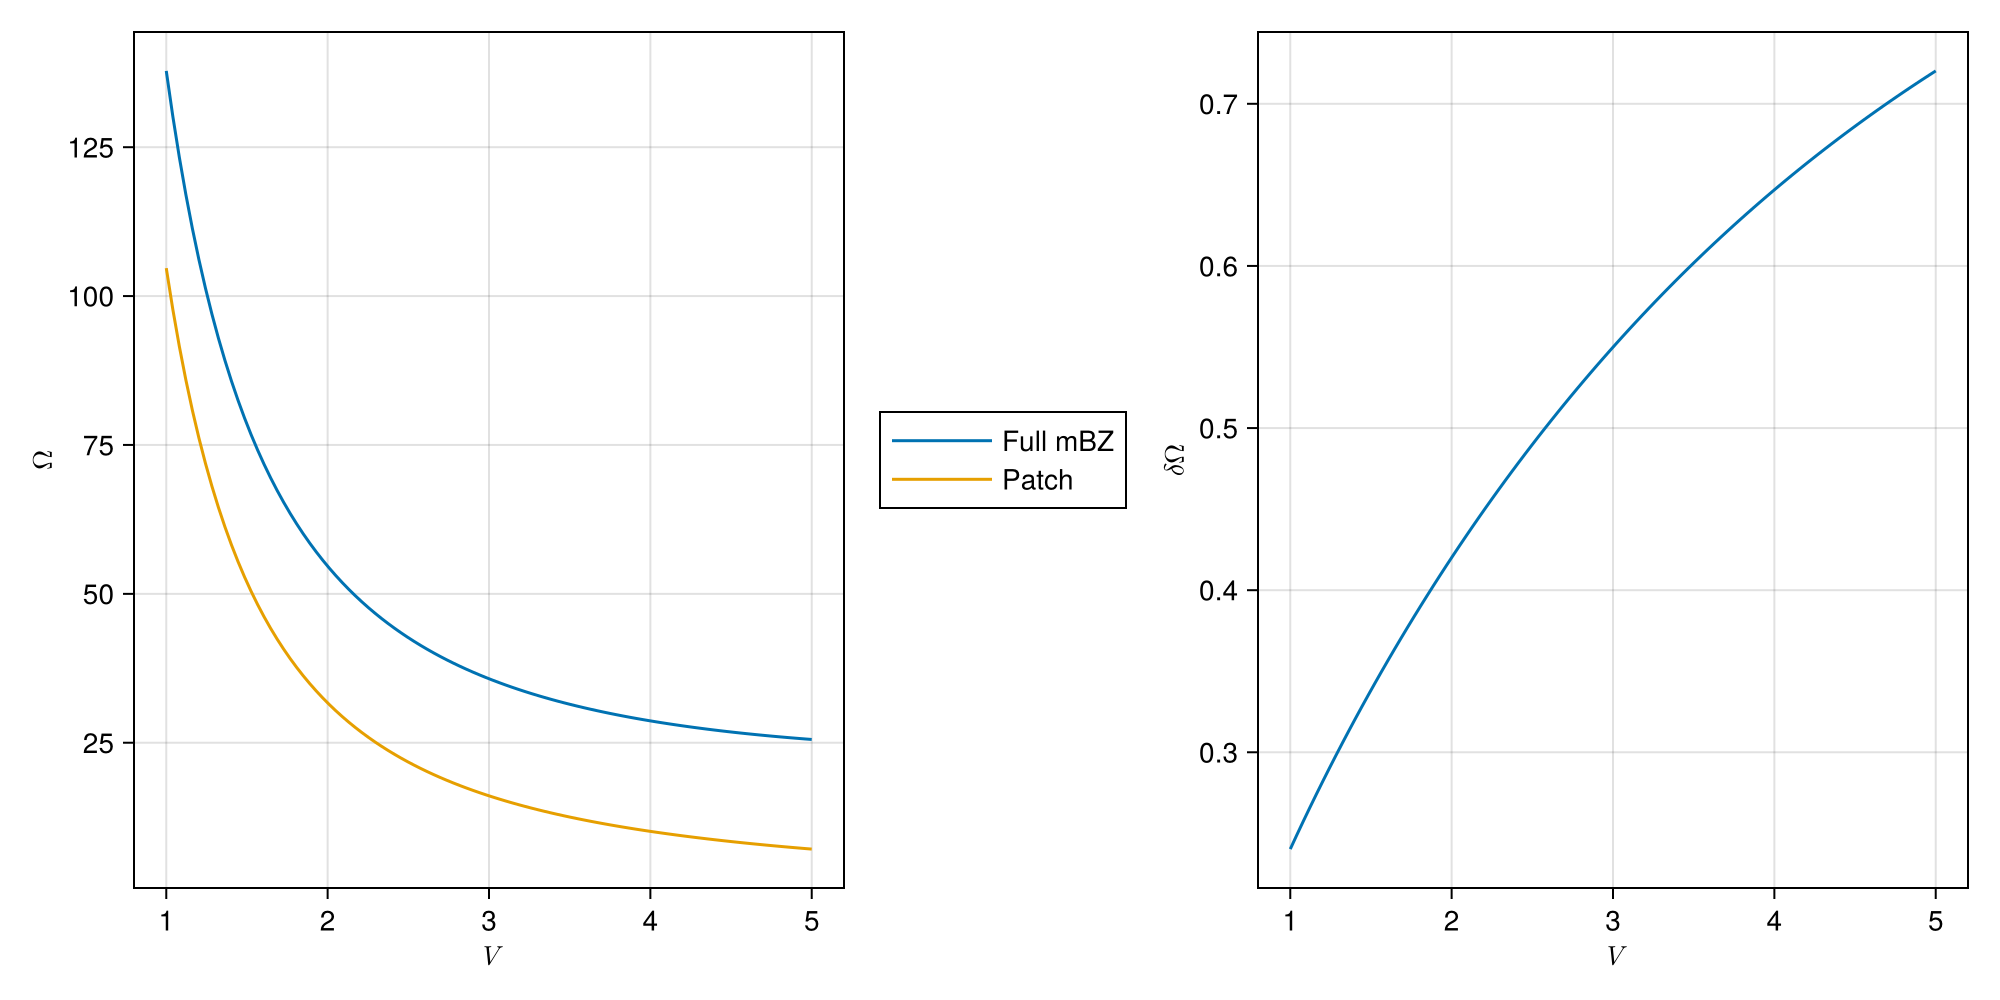

In [9]:
kappa = 1
nu = 0.5
Nl = 3
spacing = 10^(-4)
compare_origin_V(spacing, kappa, nu, Nl)

In [10]:
function compare_origin_nu(spacing, kappa, V, Nl)
    origin = [0.0, 0.0]
    kappa_1 = kappa * [1, 0.0]
    nu_list = range(0.1, 0.9, 10^2)
    full_mBZ_list = Array{Float64}(undef, length(nu_list))
    patch_list = Array{Float64}(undef, length(nu_list))
    for j in 1:length(nu_list)
        nu = nu_list[j]
        full_mBZ_list[j] = rmg_full_mBZ_bc(reshape(kappa_1, (1, 2)), spacing, Nl, nu, kappa, V)[1]
        
        delta = V/2 * rmg_delta_all(kappa, nu, Nl)
        alpha = V/2 * rmg_alpha_all(kappa, nu, Nl)
        vF = 3 * kappa^2
        patch_list[j] = rmg_patch_bc(reshape(origin, (1, 2)), spacing, Nl, nu, kappa, vF, delta, alpha)[1]
    end
    P = Figure(size=(1000, 500))
    ax1 = Axis(P[1, 1], xlabel = L"\nu", ylabel = L"\Omega")
    #lines!(ax1, nu_list, log10.(abs.((full_mBZ_list .- patch_list)./full_mBZ_list)) , label = "Full mBZ")
    lines!(ax1, nu_list, full_mBZ_list , label = "Full mBZ")
    lines!(ax1, nu_list, patch_list, label = "Patch")

    ax2 = Axis(P[1, 3], xlabel = L"\nu", ylabel = L"\delta \Omega")
    lines!(ax2, nu_list, abs.((full_mBZ_list - patch_list)./full_mBZ_list))

    P[1, 2] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)
    P
end

compare_origin_nu (generic function with 1 method)

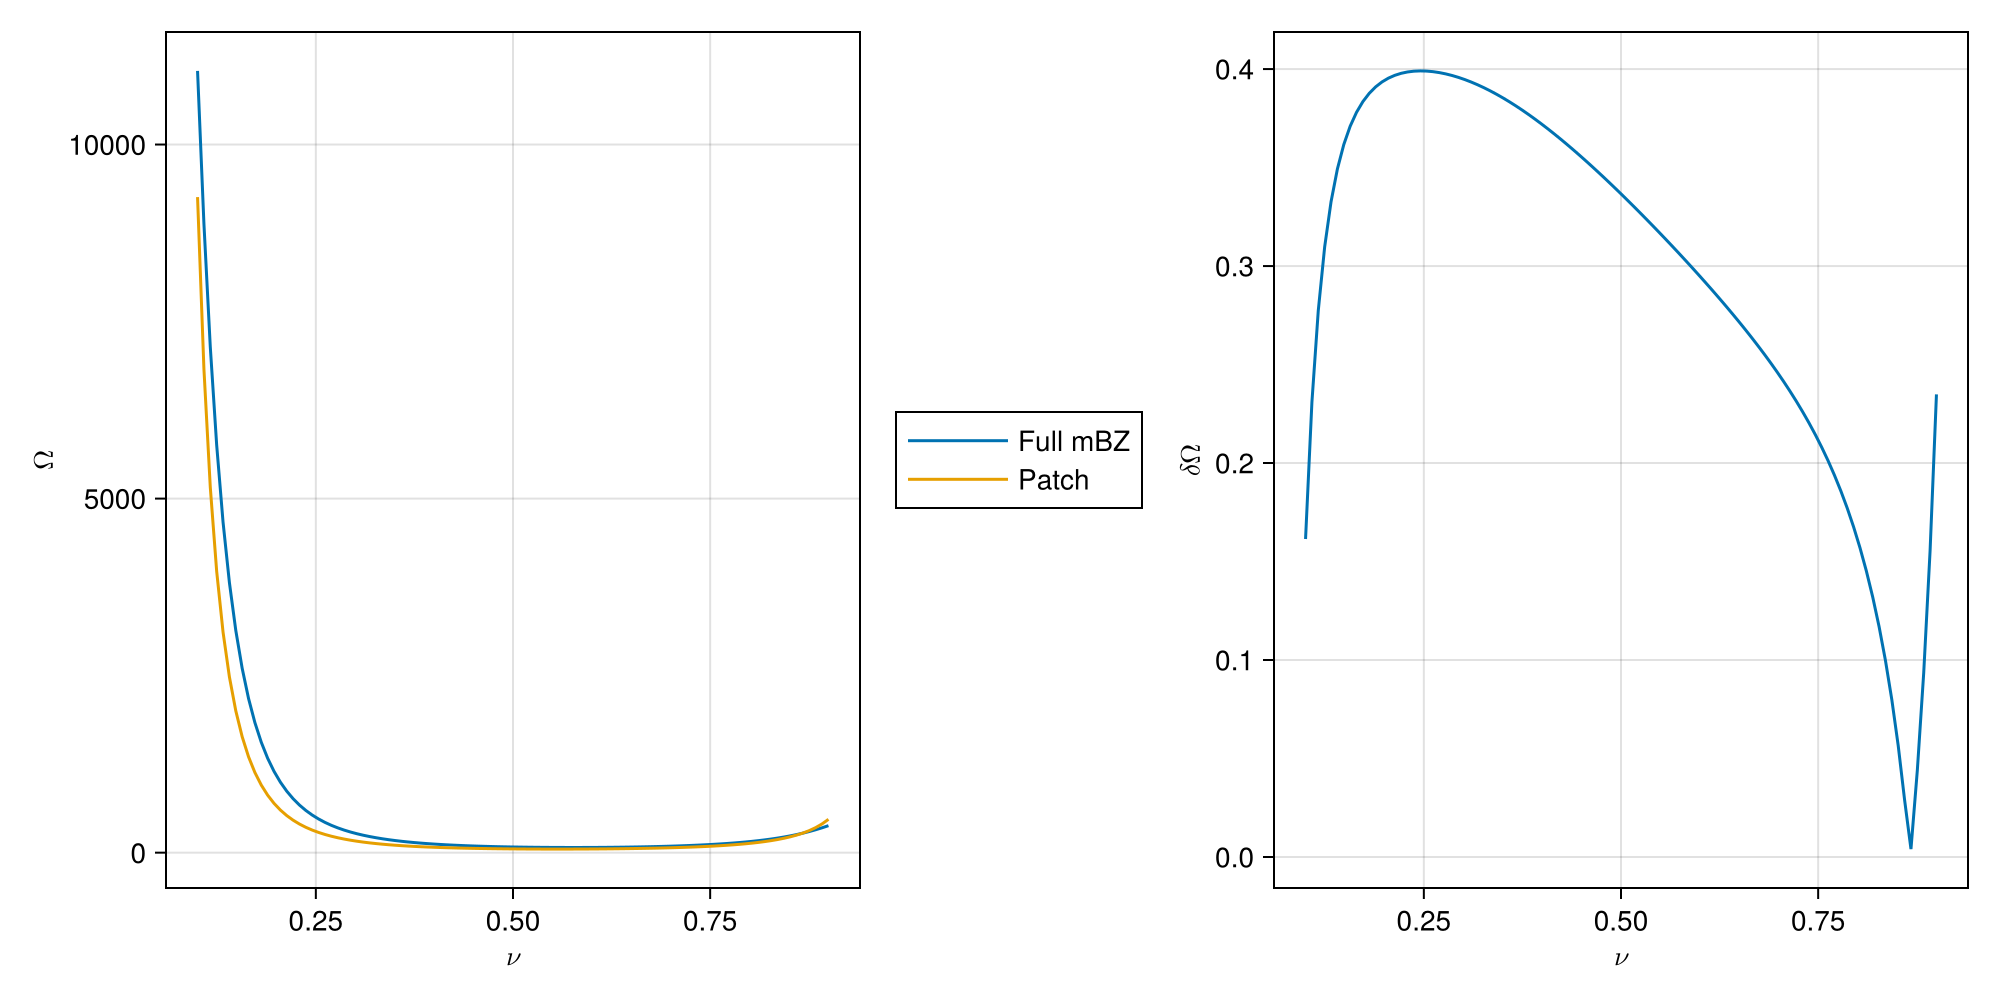

In [11]:
kappa = 1
V = 1.5
Nl = 3
spacing = 10^(-4)
compare_origin_nu(spacing, kappa, V, Nl)

# Linear potential

In [12]:
function mBZ_berry_linear(pd, Nl, nu, kappa, V)
    spacing = 10^(-3) * (kappa / pd)
    fig = Figure(size=(2000, 1500), fontsize=50, fonts = (; regular = "italic", weird = "bold"))
    ax1 = Axis(fig[1, 1], title = L"\Omega \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")

    # grid = make_hex([0, 0], kappa, kappa / pd)

    k_list = range(-2*kappa, 2*kappa, 10^2)
    grid = mesh_grid(k_list, k_list, Float64)
    
    bc_list = rmg_full_mBZ_bc_linear(grid, spacing, Nl, nu, kappa, V)

    # bc_list = rmg_spinor_bc(grid, spacing, Nl, nu)

    zmax, zmin = maximum(bc_list), minimum(bc_list)

    zabs = maximum([abs(zmax), abs(zmin)])

    levels = range(-zabs, zabs, 10)


    tr1 = tricontourf!(ax1, grid[:, 1], grid[:, 2], bc_list, colormap = :RdBu, levels = levels)
    cb1 = Colorbar(fig[1, 2], tr1)
    fig
end

mBZ_berry_linear (generic function with 1 method)

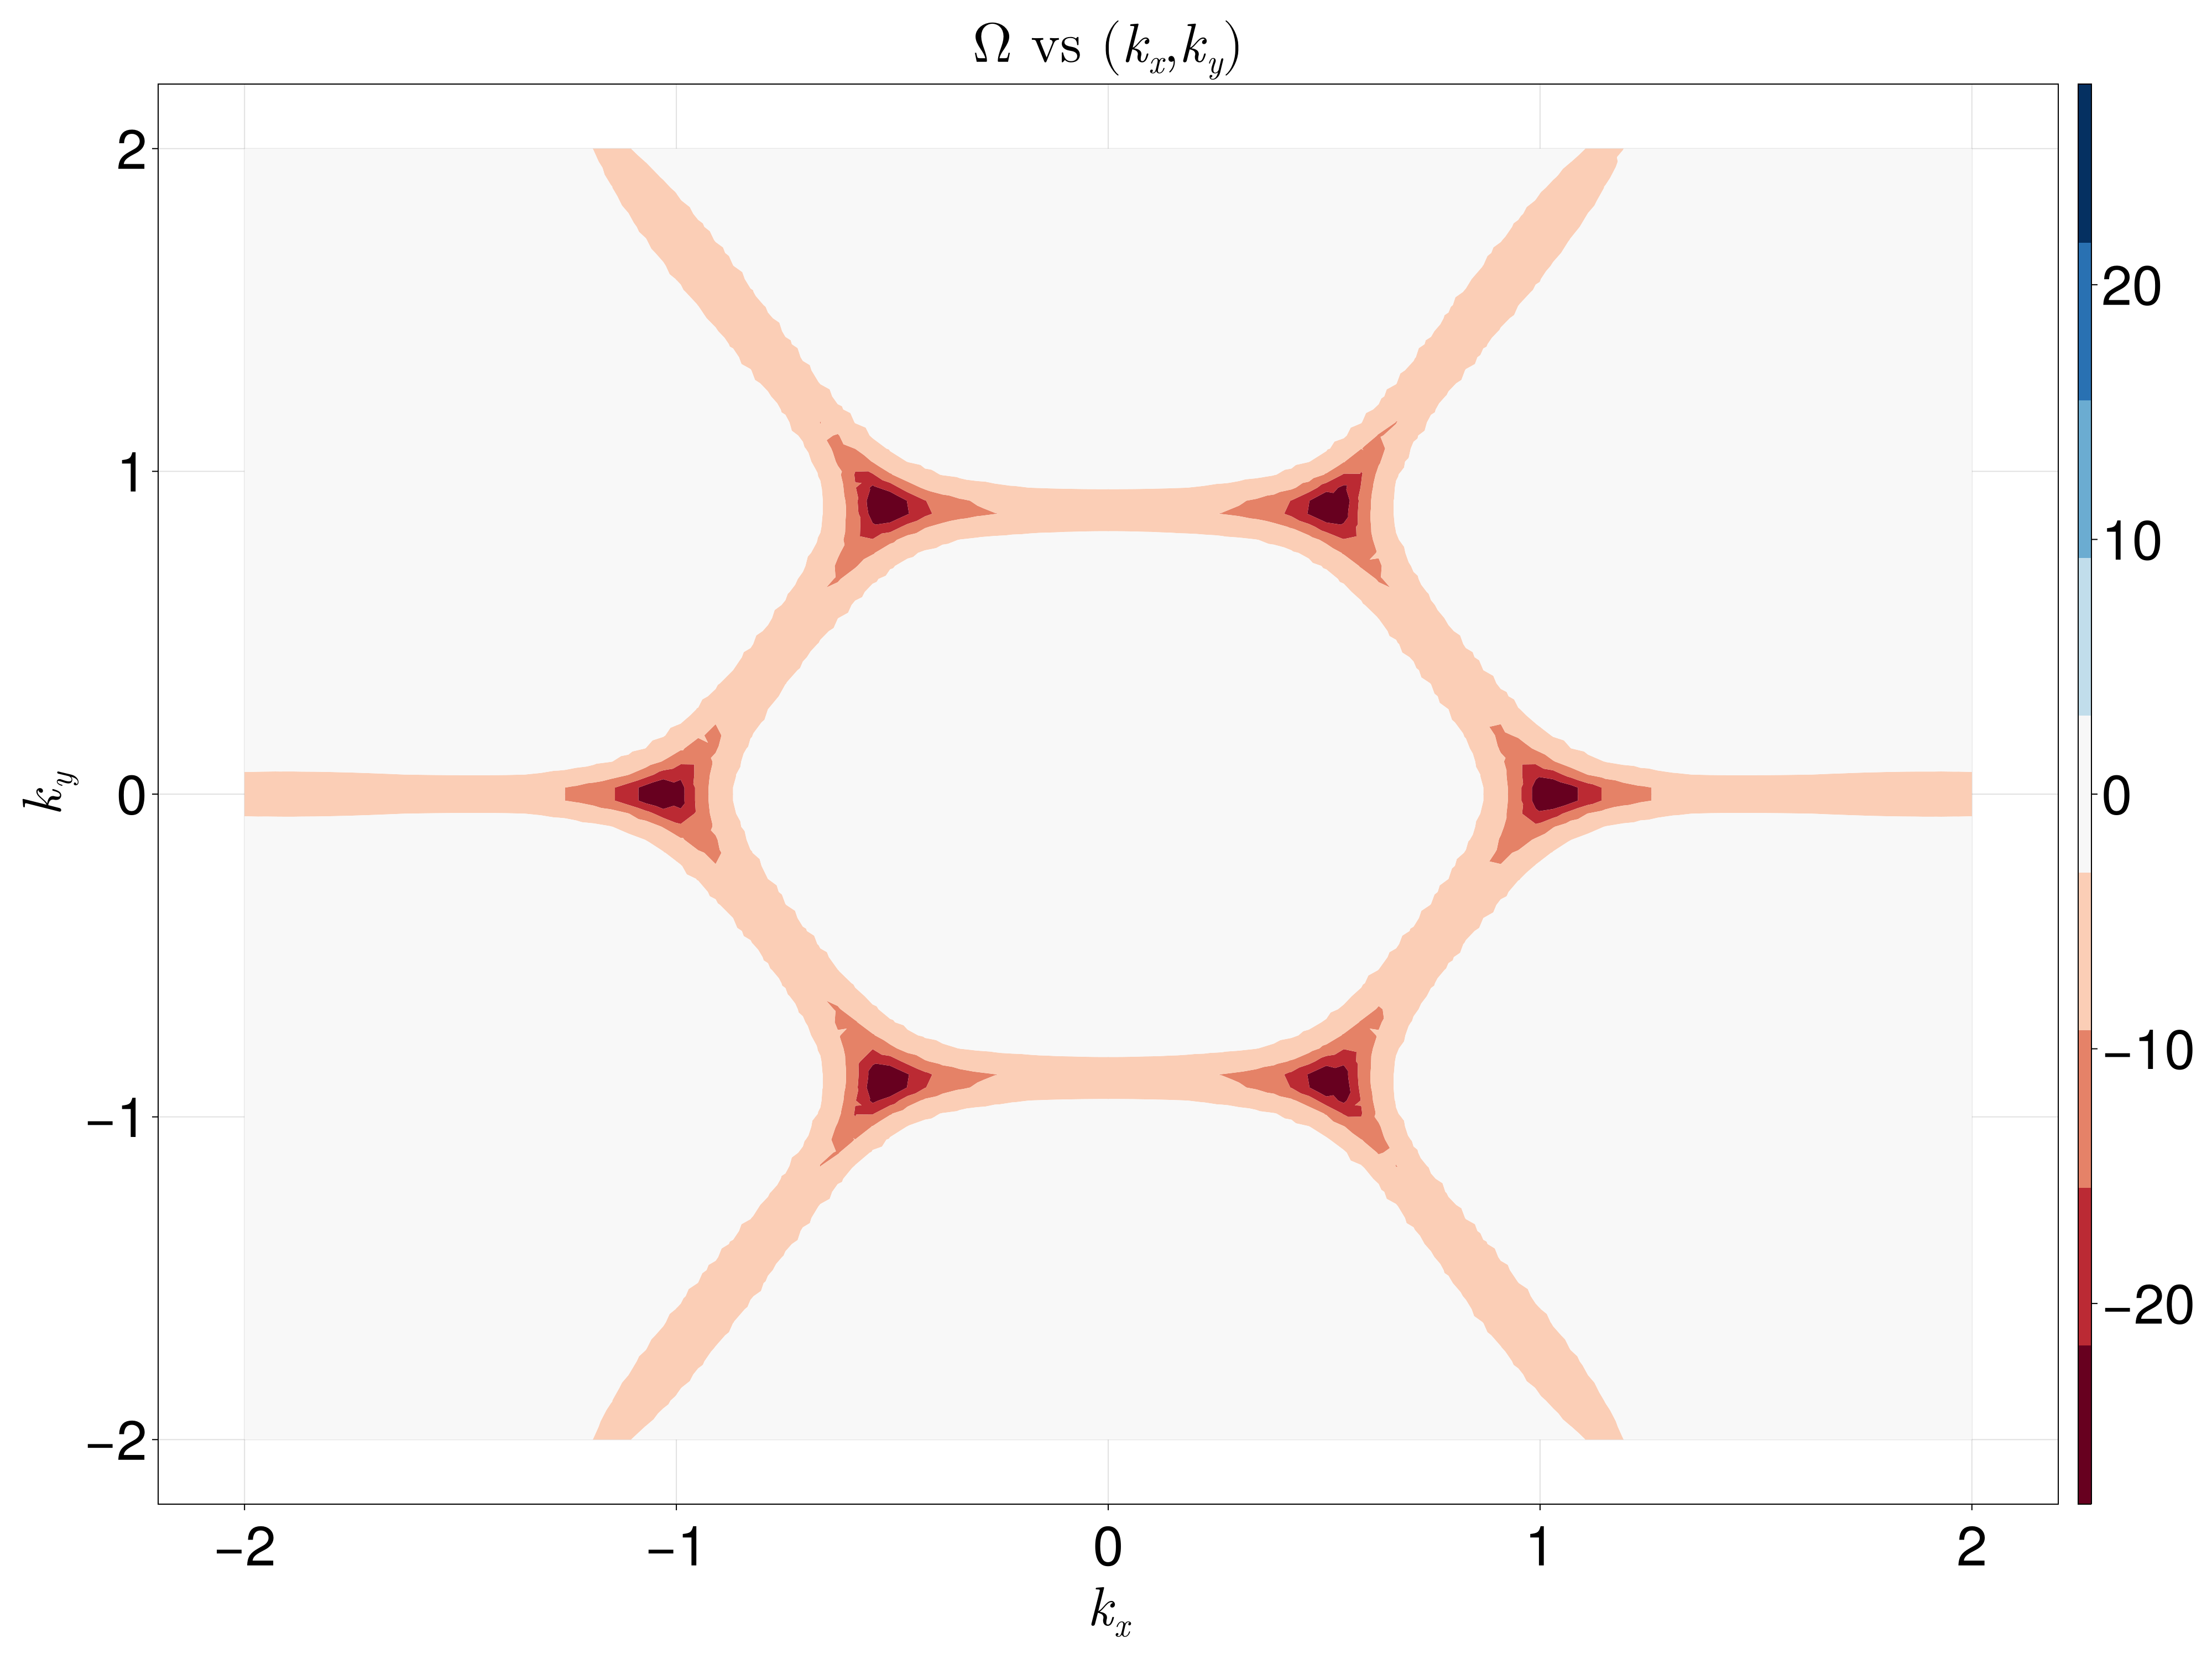

In [13]:
pd = 100
Nl = 3
nu = 0.5
kappa = 1
V = -2
mBZ_berry_linear(pd, Nl, nu, kappa, V)

# Comparison against 3-patch Berry Curvature (linear)

In [14]:
function compare_origin_V_linear(spacing, kappa, nu, Nl)
    origin = [0.0, 0.0]
    kappa_1 = kappa * [1, 0.0]
    q = [0, 0]
    V_list = range(0.01, 0.1, 10^2)
    full_mBZ_list = Array{Float64}(undef, length(V_list))
    patch_list = Array{Float64}(undef, length(V_list))
    for j in 1:length(V_list)
        V = V_list[j]
        full_mBZ_list[j] = rmg_full_mBZ_bc_linear(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, V)[1]
        
        delta = V/2 * rmg_delta_linear(kappa, nu, Nl)
        alpha = V/2 * rmg_alpha_linear(kappa, nu, Nl)
        vF = 3 * kappa^2
        # patch_list[j] = rmg_full_mBZ_bc(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, 0.000000001)[1]
        patch_list[j] = rmg_patch_bc(reshape(origin + q, (1, 2)), spacing, Nl, nu, kappa, vF, delta, alpha)[1]
    end
    P = Figure(size=(1000, 500))
    ax1 = Axis(P[1, 1], xlabel = L"V", ylabel = L"\Omega")
    lines!(ax1, V_list, full_mBZ_list, label = "Full mBZ")
    lines!(ax1, V_list, patch_list, label = "Patch")

    ax2 = Axis(P[1, 3], xlabel = L"V", ylabel = L"\delta \Omega")
    lines!(ax2, V_list, abs.((full_mBZ_list - patch_list)./full_mBZ_list))

    # ax2 = Axis(P[1, 2], xlabel = L"V", 
    # ylabel = L"\delta \Omega")
    # lines!(ax2, V_list, full_mBZ_list ./ patch_list)

    P[1, 2] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)
    P
end

compare_origin_V_linear (generic function with 1 method)

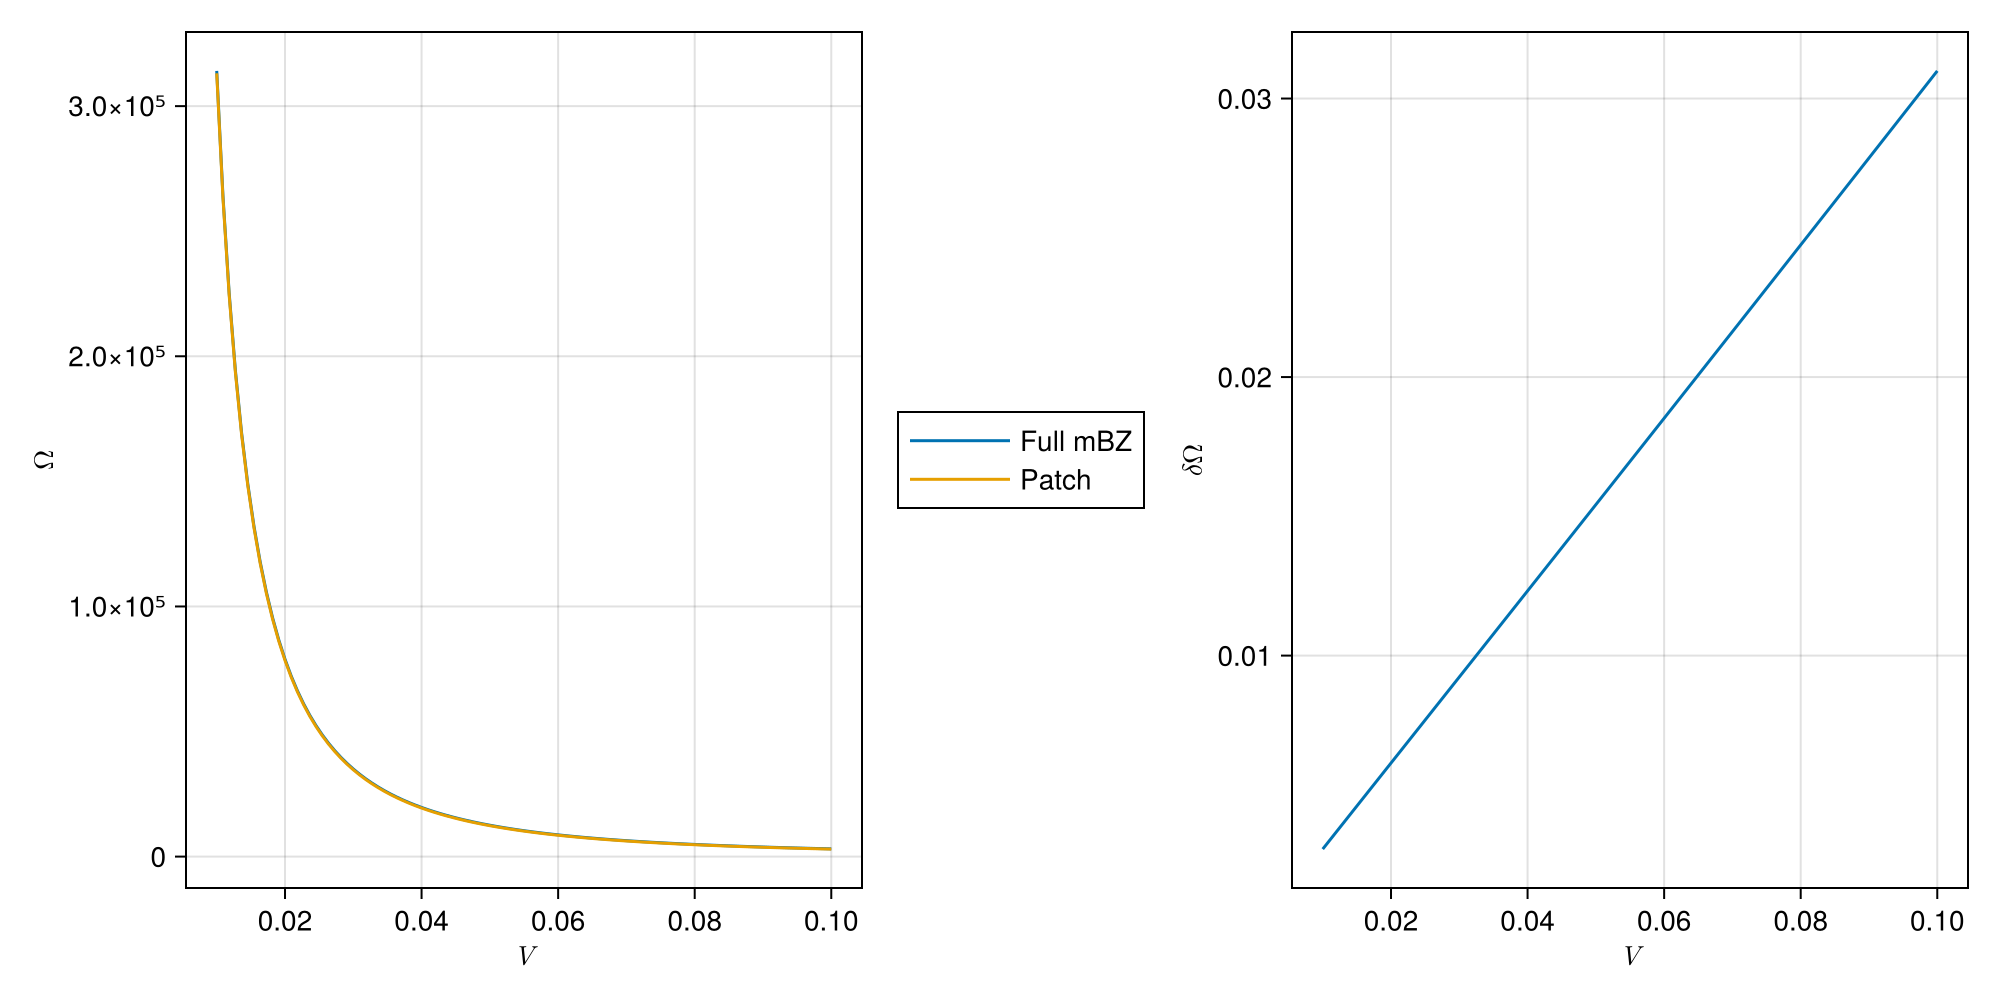

In [15]:
kappa = 1
nu = 0.6
Nl = 3
spacing = 10^(-4)
compare_origin_V_linear(spacing, kappa, nu, Nl)

In [16]:
function compare_origin_nu_linear(spacing, kappa, V, Nl)
    origin = [0.0, 0.0]
    kappa_1 = kappa * [1, 0.0]
    nu_list = range(0.1, 1.7, 10^2)
    full_mBZ_list = Array{Float64}(undef, length(nu_list))
    patch_list = Array{Float64}(undef, length(nu_list))
    for j in 1:length(nu_list)
        nu = nu_list[j]
        full_mBZ_list[j] = rmg_full_mBZ_bc_linear(reshape(kappa_1, (1, 2)), spacing, Nl, nu, kappa, V)[1]
        
        delta = V/2 * rmg_delta_linear(kappa, nu, Nl)
        alpha = V/2 * rmg_alpha_linear(kappa, nu, Nl)
        vF = 3 * kappa^2
        patch_list[j] = rmg_patch_bc(reshape(origin, (1, 2)), spacing, Nl, nu, kappa, vF, delta, alpha)[1]
    end
    P = Figure(size=(1000, 500))
    ax1 = Axis(P[1, 1], xlabel = L"\nu", ylabel = L"\Omega")
    #lines!(ax1, nu_list, log10.(abs.((full_mBZ_list .- patch_list)./full_mBZ_list)) , label = "Full mBZ")
    lines!(ax1, nu_list, full_mBZ_list , label = "Full mBZ")
    lines!(ax1, nu_list, patch_list, label = "Patch")

    ax2 = Axis(P[1, 3], xlabel = L"\nu", ylabel = L"\delta \Omega")
    lines!(ax2, nu_list, abs.((full_mBZ_list - patch_list)./full_mBZ_list))

    P[1, 2] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)
    P
end

compare_origin_nu_linear (generic function with 1 method)

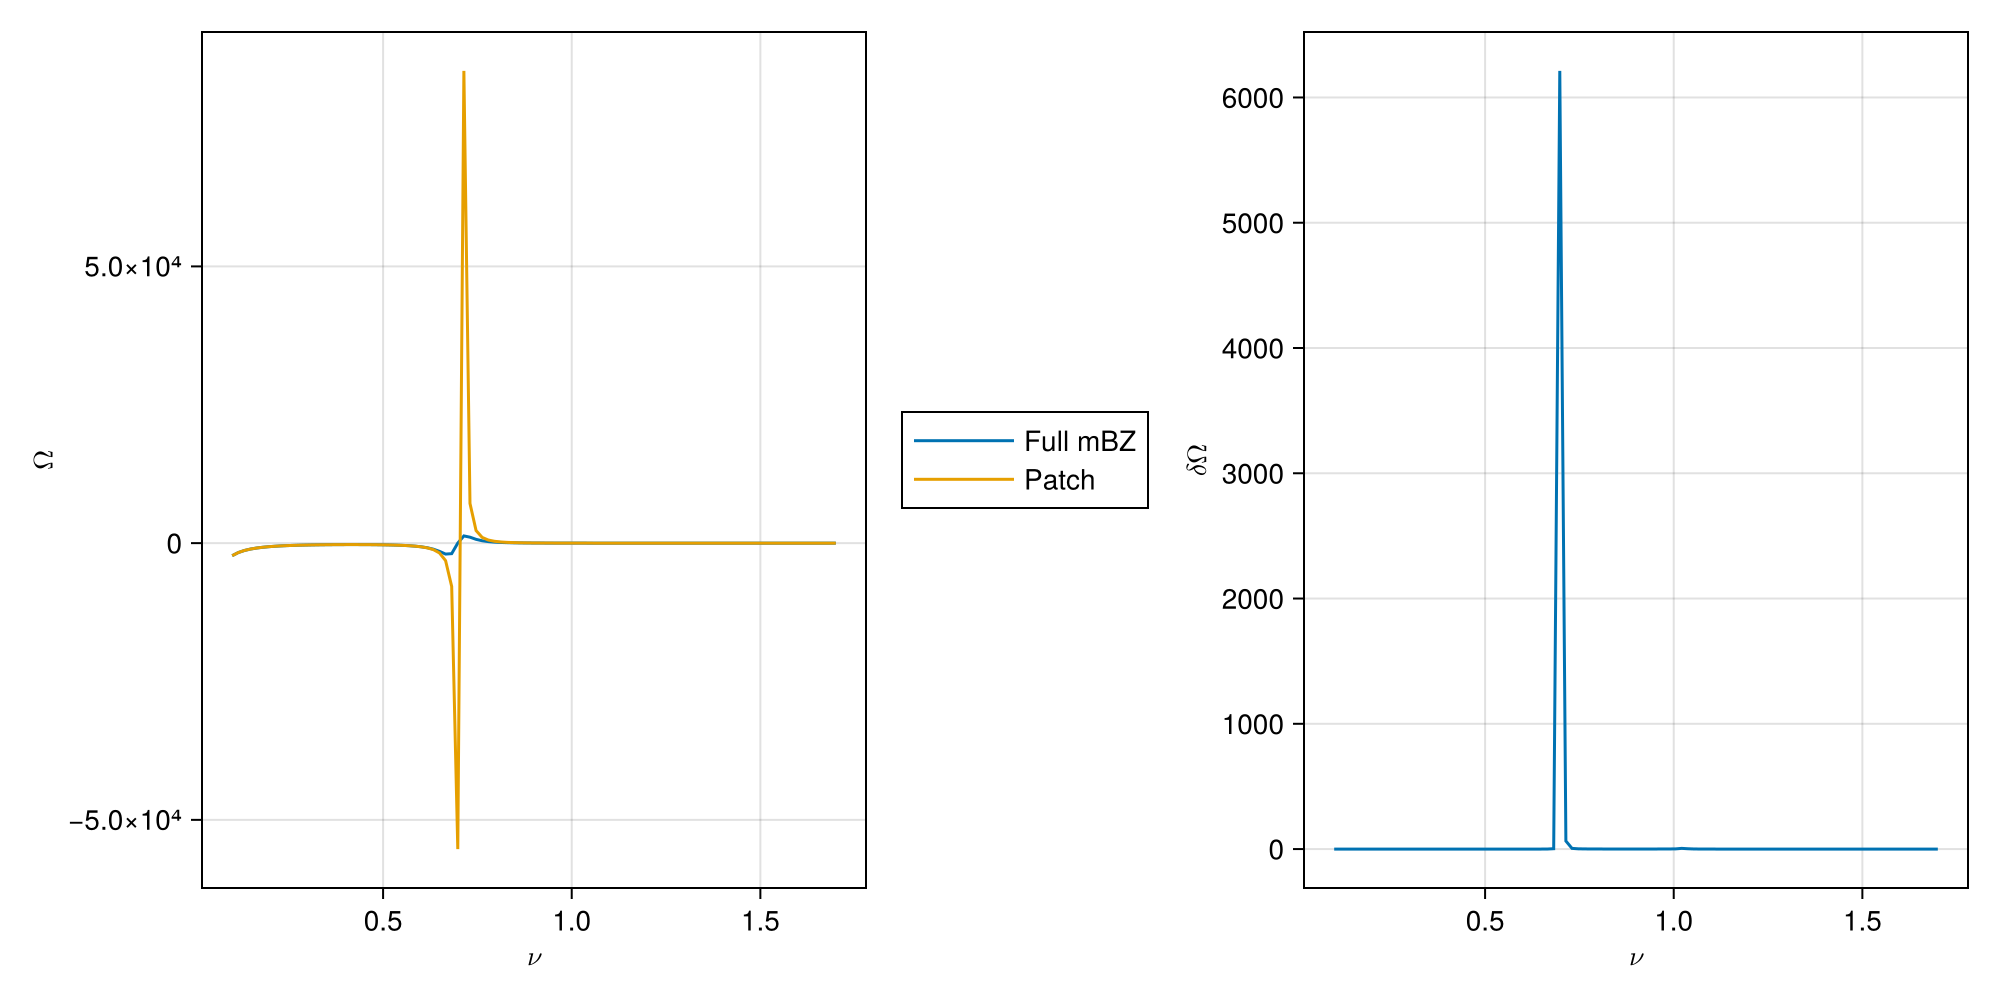

In [17]:
kappa = 1
V = -0.7
Nl = 3
spacing = 10^(-4)
compare_origin_nu_linear(spacing, kappa, V, Nl)

# Experiments with many shells

In [18]:
function compare_origin_V_shells(spacing, kappa, nu, Nl, shells)
    origin = [0.0, 0.0]
    kappa_1 = kappa * [1, 0.0]
    q = [0.01, 0.01]
    V_list = range(1, 5, 10^2)
    full_mBZ_list = Array{Float64}(undef, length(V_list))
    patch_list = Array{Float64}(undef, length(V_list))
    for j in 1:length(V_list)
        V = V_list[j]
        full_mBZ_list[j] = rmg_mBZ_shells_bc(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, V, shells)[1]
        
        delta = V/2 * rmg_delta_all(kappa, nu, Nl)
        alpha = V/2 * rmg_alpha_all(kappa, nu, Nl)
        vF = 3 * kappa^2
        # patch_list[j] = rmg_full_mBZ_bc(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, 0.000000001)[1]
        patch_list[j] = rmg_patch_bc(reshape(origin + q, (1, 2)), spacing, Nl, nu, kappa, vF, delta, alpha)[1]
    end
    P = Figure(size=(1000, 500))
    ax1 = Axis(P[1, 1], xlabel = L"V", ylabel = L"\Omega")
    lines!(ax1, V_list, full_mBZ_list, label = "Full mBZ")
    lines!(ax1, V_list, patch_list, label = "Patch")

    ax2 = Axis(P[1, 3], xlabel = L"V", ylabel = L"\delta \Omega")
    lines!(ax2, V_list, abs.((full_mBZ_list - patch_list)./full_mBZ_list))

    # ax2 = Axis(P[1, 2], xlabel = L"V", 
    # ylabel = L"\delta \Omega")
    # lines!(ax2, V_list, full_mBZ_list ./ patch_list)

    P[1, 2] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)
    P
end

compare_origin_V_shells (generic function with 1 method)

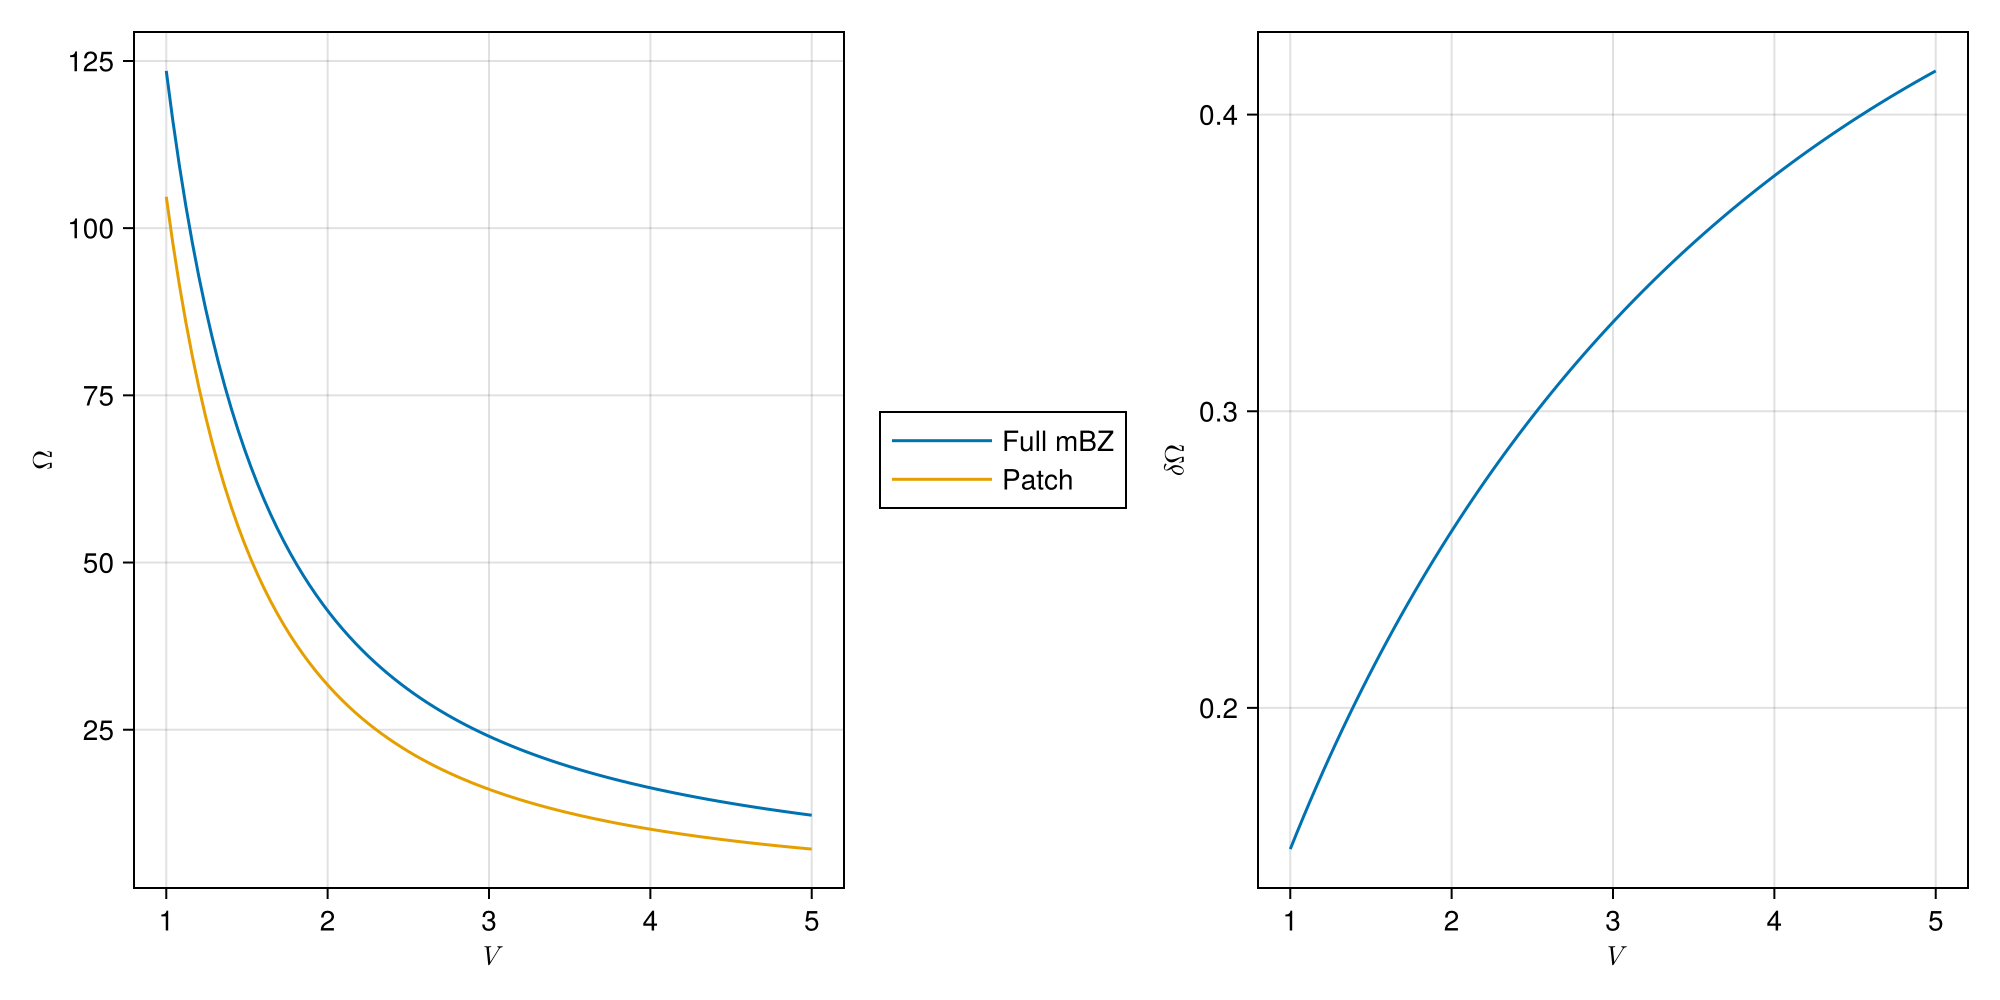

In [19]:
kappa = 1
nu = 0.5
Nl = 3
spacing = 10^(-4)
shells = 4
compare_origin_V_shells(spacing, kappa, nu, Nl, shells)

In [905]:
function compare_origin_nu_shells(spacing, kappa, V, Nl, shells)
    origin = [0.0, 0.0]
    kappa_1 = kappa * [1, 0.0]
    q = [0, 0]
    nu_list = range(0.01, 1, 10^2)
    full_mBZ_list = Array{Float64}(undef, length(nu_list))
    patch_list = Array{Float64}(undef, length(nu_list))
    for j in 1:length(nu_list)
        nu = nu_list[j]
        full_mBZ_list[j] = rmg_mBZ_shells_bc(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, V, shells)[1]
        
        delta = V/2 * rmg_delta_all(kappa, nu, Nl)
        alpha = V/2 * rmg_alpha_all(kappa, nu, Nl)
        vF = 3 * kappa^2
        patch_list[j] = rmg_patch_bc(reshape(origin, (1, 2)), spacing, Nl, nu, kappa, vF, delta, alpha)[1]
    end
    P = Figure(size=(1000, 500))
    ax1 = Axis(P[1, 1], xlabel = L"\nu", ylabel = L"\Omega")
    #lines!(ax1, nu_list, log10.(abs.((full_mBZ_list .- patch_list)./full_mBZ_list)) , label = "Full mBZ")
    lines!(ax1, nu_list, full_mBZ_list , label = "Full mBZ")
    lines!(ax1, nu_list, patch_list, label = "Patch")

    ax2 = Axis(P[1, 3], xlabel = L"\nu", ylabel = L"\delta \Omega")
    lines!(ax2, nu_list, abs.((full_mBZ_list - patch_list)./full_mBZ_list))

    P[1, 2] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)
    P
end

compare_origin_nu_shells (generic function with 1 method)

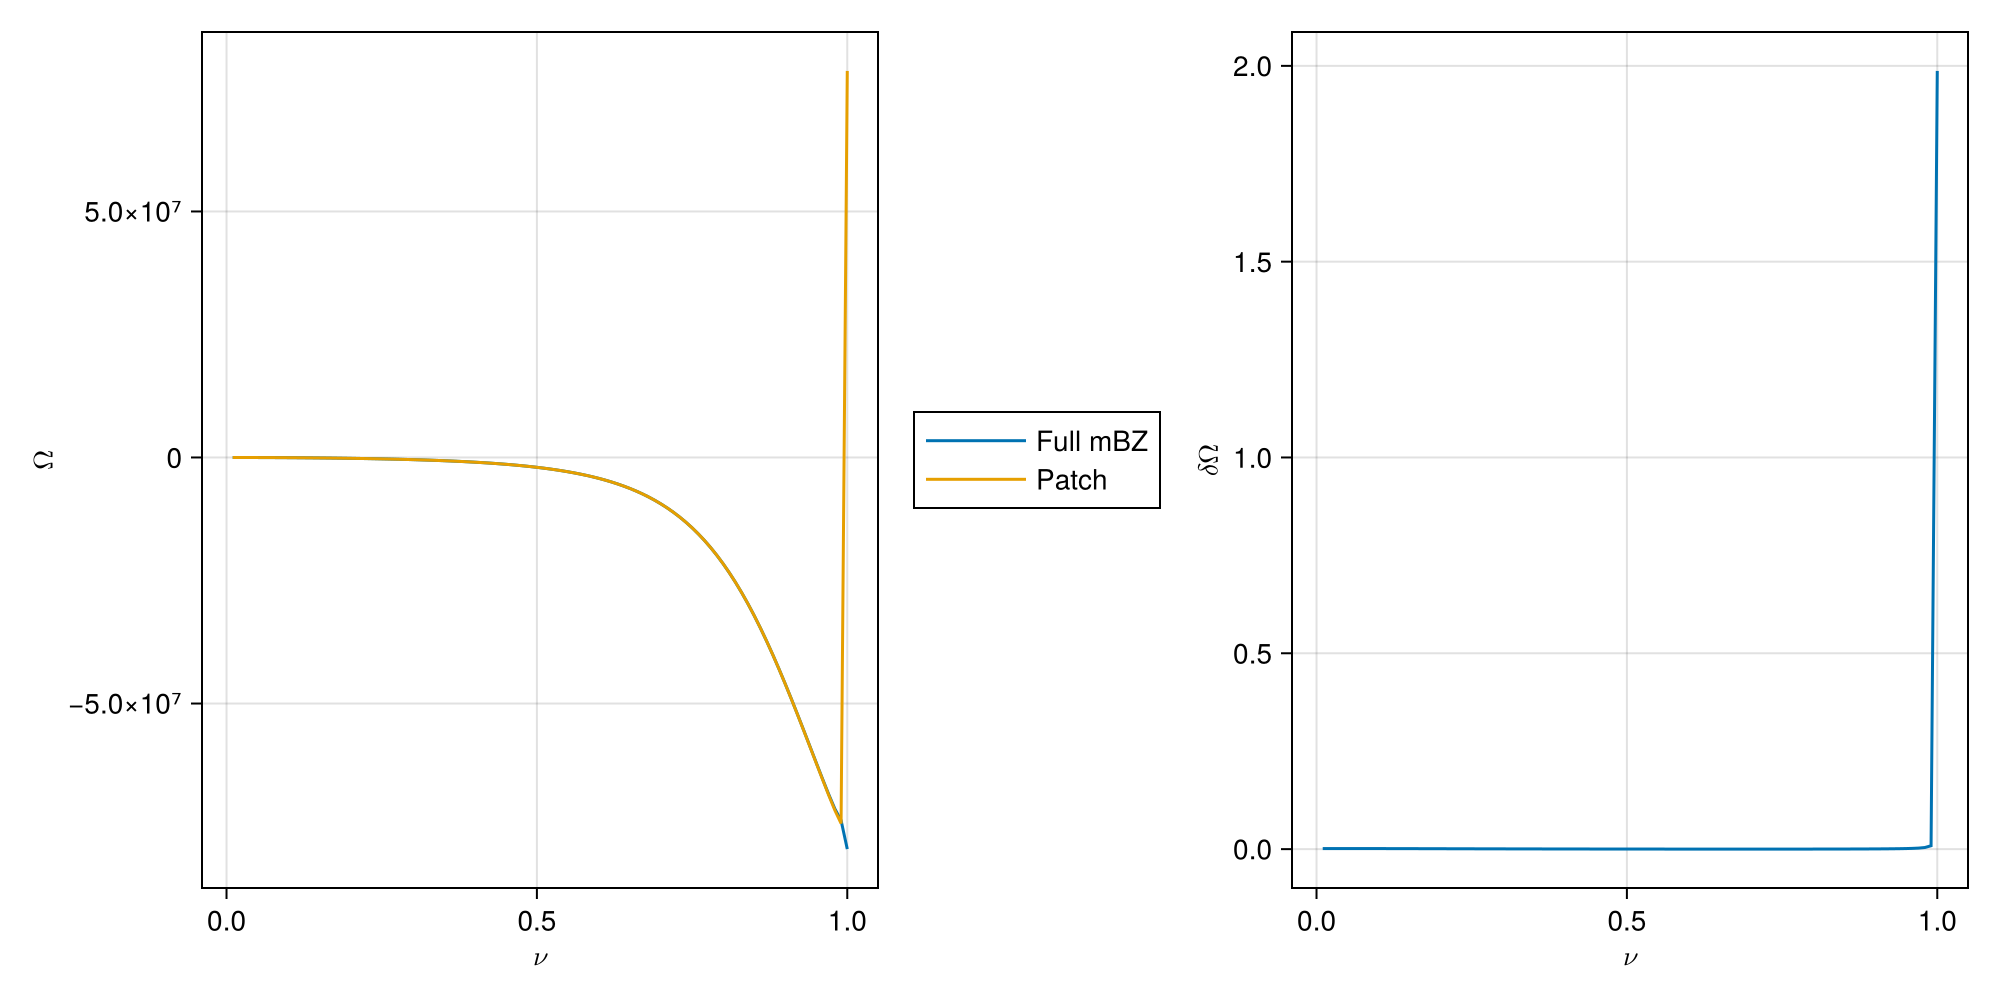

In [907]:
kappa = 1
V = -0.001
Nl = 3
spacing = 10^(-4)
shells = 3
compare_origin_nu_shells(spacing, kappa, V, Nl, shells)

In [778]:
function mBZ_berry_linear(pd, Nl, nu, kappa, V)
    spacing = 10^(-3) * (kappa / pd)
    fig = Figure(size=(2500, 1500), fontsize=50, fonts = (; regular = "italic", weird = "bold"))
    ax1 = Axis(fig[1, 1], title = L"\Omega \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")
    ax2 = Axis(fig[1, 3], title = L"\Omega \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")

    # grid = make_hex([0, 0], kappa, kappa / pd)

    k_list = range(-10*kappa, 10*kappa, 10^2)
    grid = mesh_grid(k_list, k_list, Float64)
    
    bc_list = rmg_full_mBZ_bc_linear(grid, spacing, Nl, nu, kappa, V)

    bc_list2 = rmg_mBZ_shells_bc_linear(grid, spacing, Nl, nu, kappa, V, 3)

    # bc_list = rmg_spinor_bc(grid, spacing, Nl, nu)

    zmax, zmin = maximum(bc_list), minimum(bc_list)

    zabs = maximum([abs(zmax), abs(zmin)])

    levels = range(-zabs, zabs, 10)


    tr1 = tricontourf!(ax1, grid[:, 1], grid[:, 2], bc_list, colormap = :RdBu, levels = levels)
    cb1 = Colorbar(fig[1, 2], tr1)

    zmax, zmin = maximum(bc_list2), minimum(bc_list2)

    zabs = maximum([abs(zmax), abs(zmin)])

    levels = range(-zabs, zabs, 10)

    tr2 = tricontourf!(ax2, grid[:, 1], grid[:, 2], bc_list2, colormap = :RdBu, levels = levels)
    cb2 = Colorbar(fig[1, 4], tr2)
    fig
end

mBZ_berry_linear (generic function with 1 method)

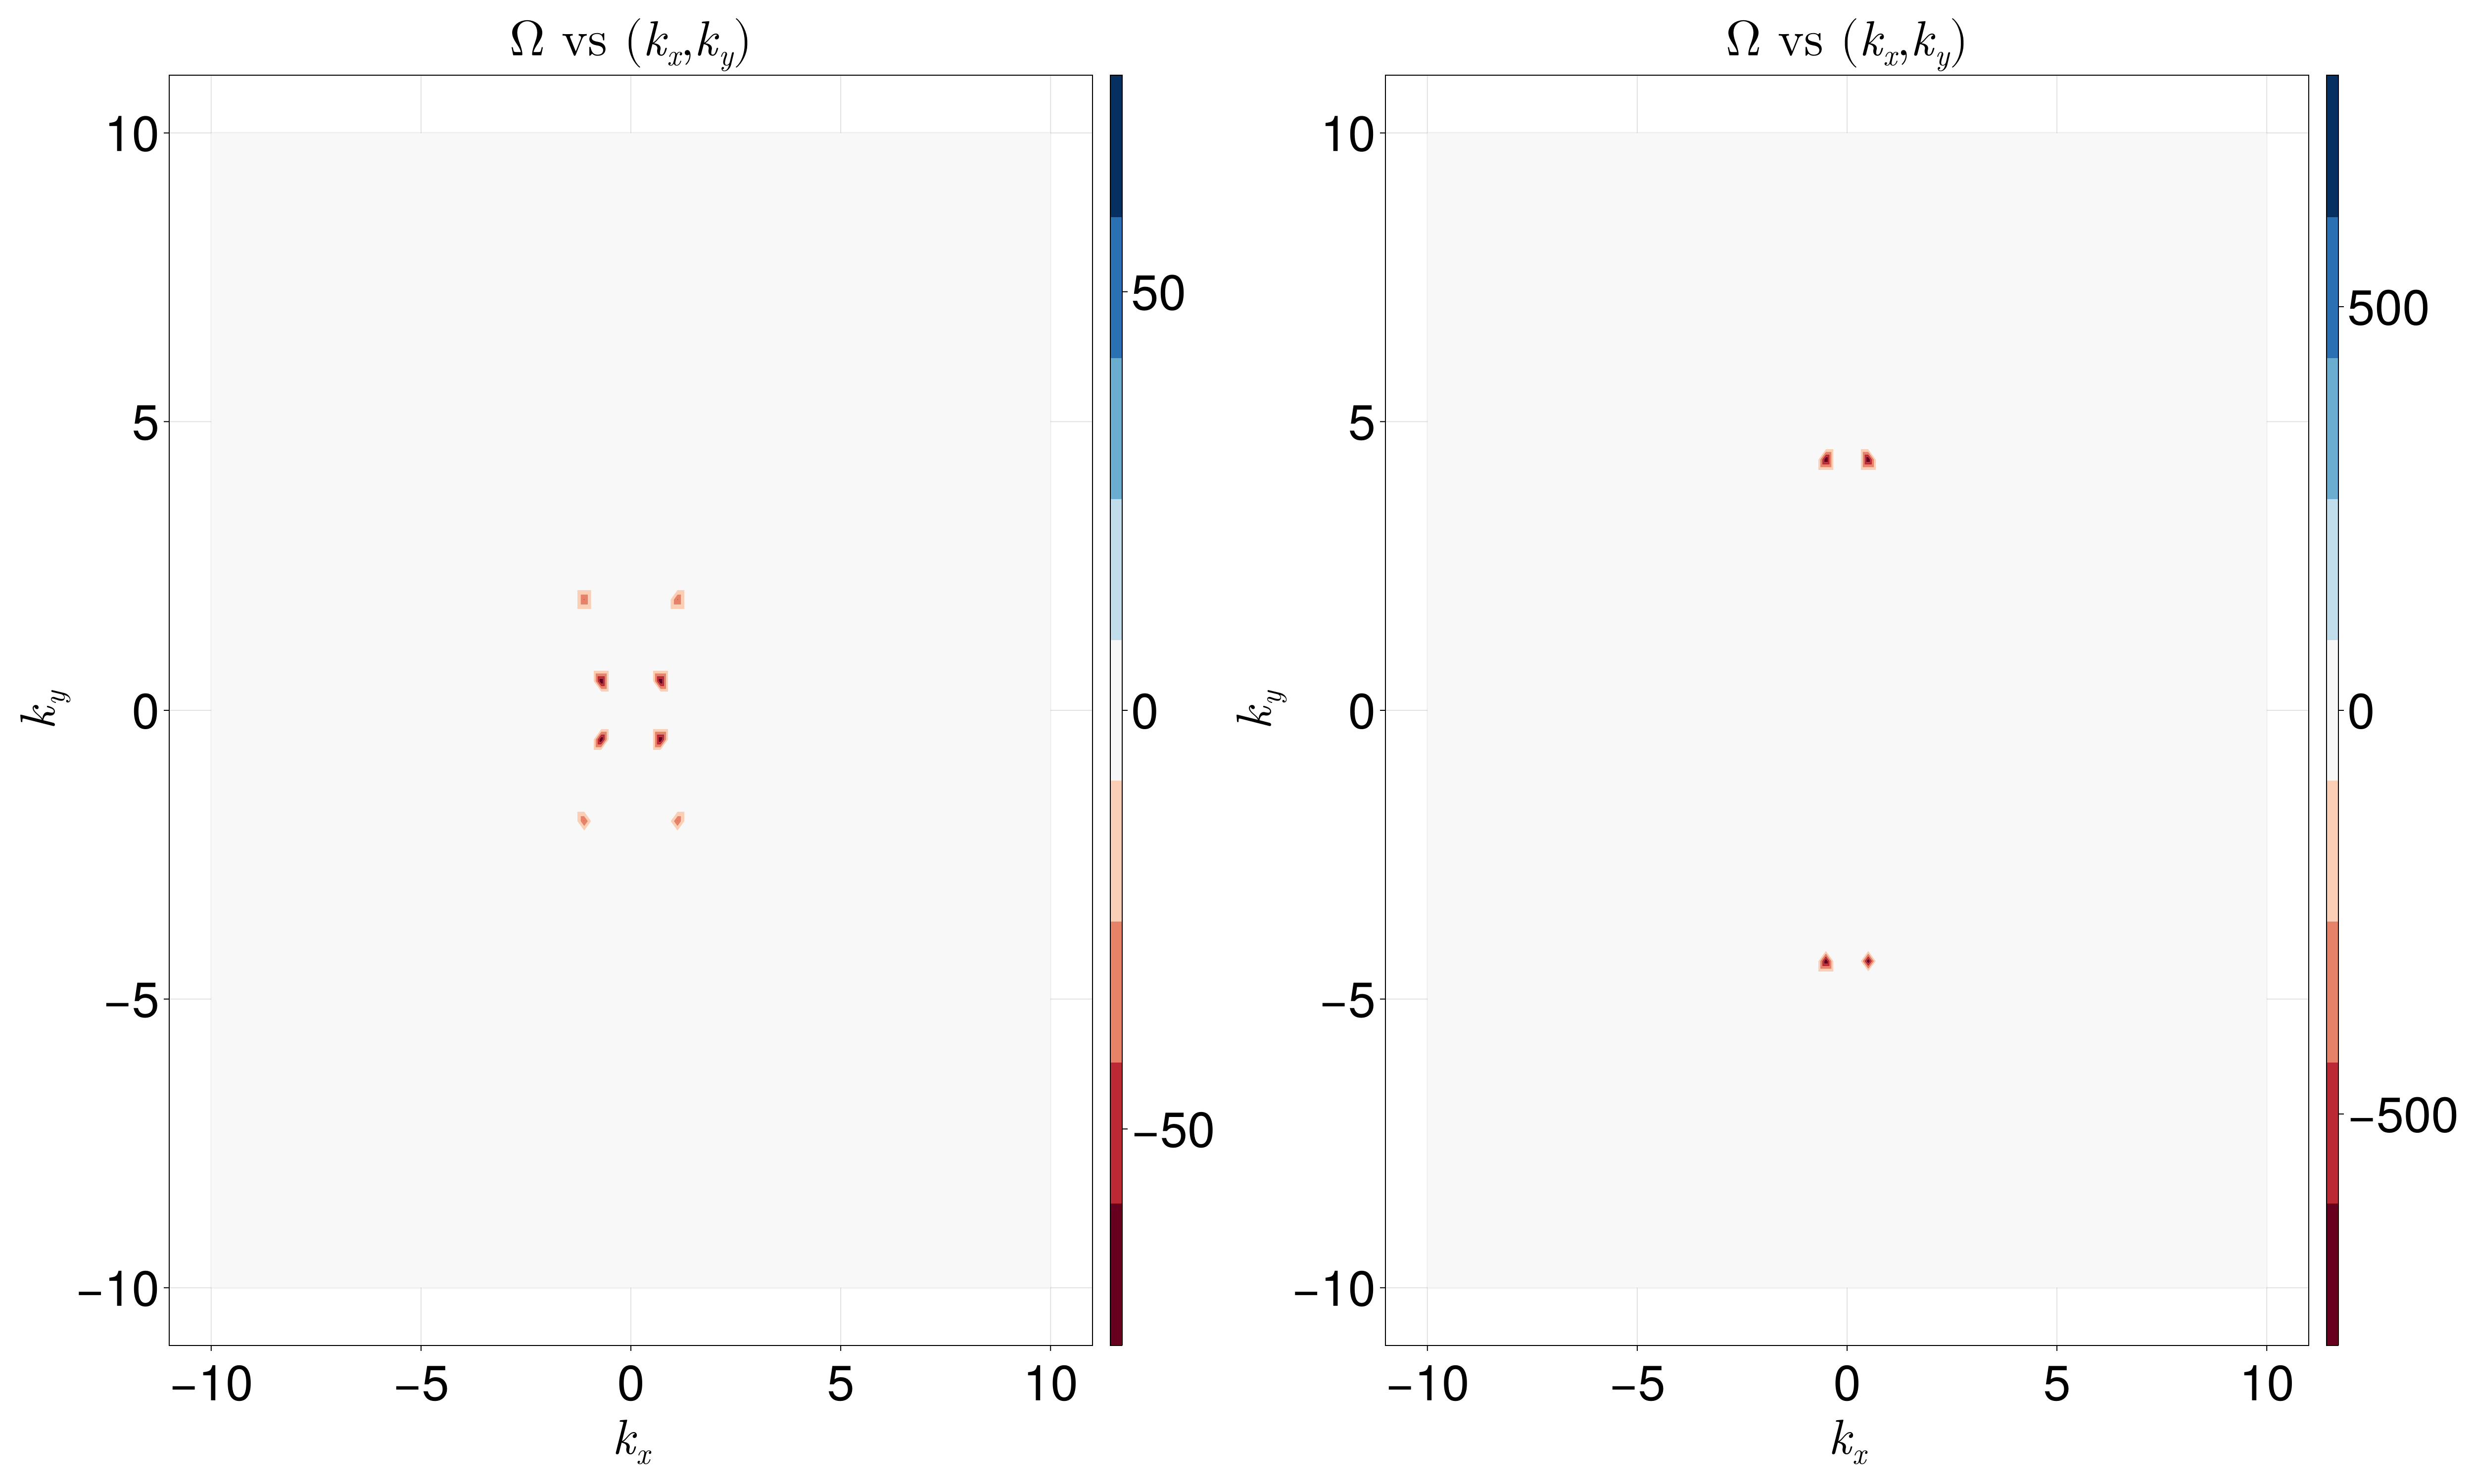

In [674]:
pd = 60
Nl = 3
nu = 0.5
kappa = 1
V = -0.1
mBZ_berry_linear(pd, Nl, nu, kappa, V)

In [582]:
function compare_origin_V_linear_shells(spacing, kappa, nu, Nl, shells)
    origin = [0.0, 0.0]
    kappa_1 = kappa * [1, 0.0]
    q = [0, 0]
    V_list = range(0, 10, 10^2)
    full_mBZ_list = Array{Float64}(undef, length(V_list))
    patch_list = Array{Float64}(undef, length(V_list))
    for j in 1:length(V_list)
        V = V_list[j]
        full_mBZ_list[j] = rmg_mBZ_shells_bc_linear(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, V, shells)[1]
        
        delta = V/2 * rmg_delta_linear(kappa, nu, Nl)
        alpha = V/2 * rmg_alpha_linear(kappa, nu, Nl)
        vF = 3 * kappa^2
        # patch_list[j] = rmg_full_mBZ_bc(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, 0.000000001)[1]
        patch_list[j] = rmg_patch_bc(reshape(origin + q, (1, 2)), spacing, Nl, nu, kappa, vF, delta, alpha)[1]
    end
    P = Figure(size=(1000, 500))
    ax1 = Axis(P[1, 1], xlabel = L"V", ylabel = L"\Omega")
    lines!(ax1, V_list, full_mBZ_list, label = "Full mBZ")
    lines!(ax1, V_list, patch_list, label = "Patch")

    ax2 = Axis(P[1, 3], xlabel = L"V", ylabel = L"\delta \Omega")
    lines!(ax2, V_list, abs.((full_mBZ_list - patch_list)./full_mBZ_list))

    # ax2 = Axis(P[1, 2], xlabel = L"V", 
    # ylabel = L"\delta \Omega")
    # lines!(ax2, V_list, full_mBZ_list ./ patch_list)

    P[1, 2] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)
    P
end

compare_origin_V_linear_shells (generic function with 1 method)

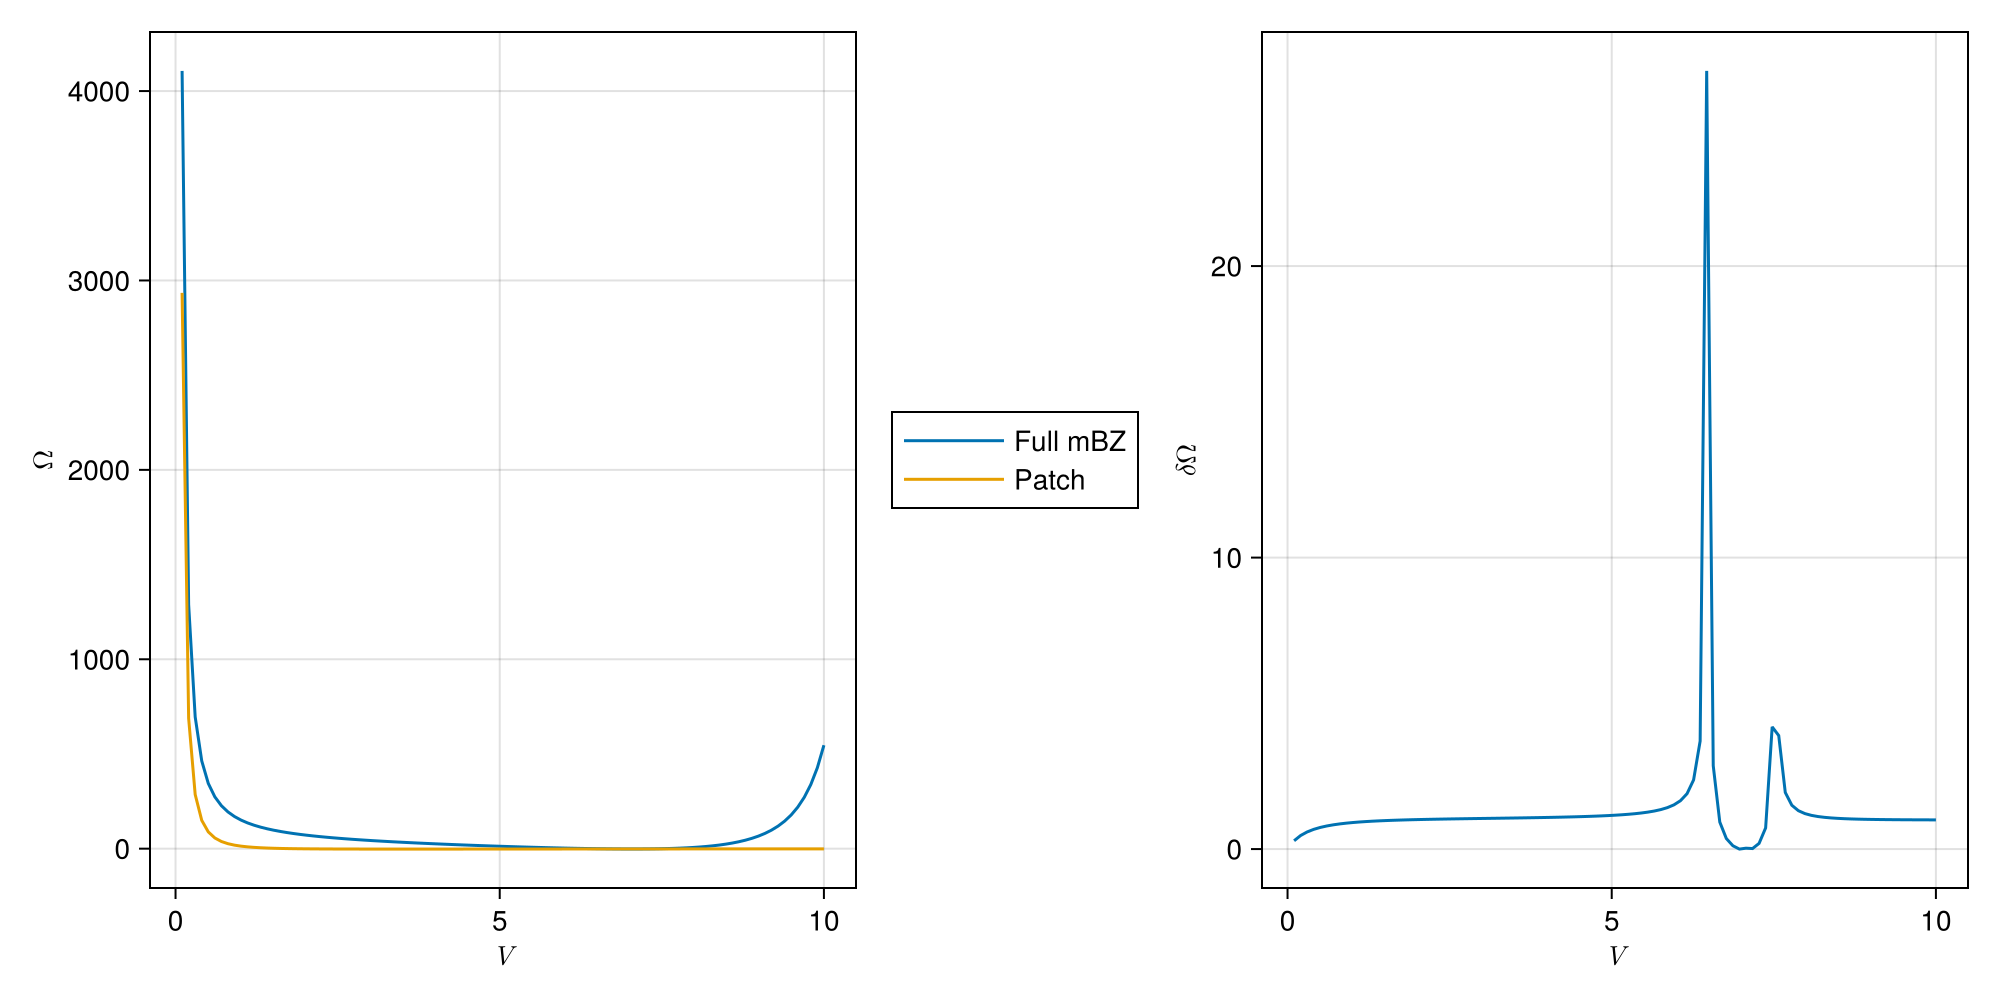

In [583]:
kappa = 1
nu = 0.6
Nl = 3
spacing = 10^(-4)
shells = 9
compare_origin_V_linear_shells(spacing, kappa, nu, Nl, shells)

In [908]:
function compare_origin_nu_linear_shells(spacing, kappa, V, Nl, shells)
    origin = [0.0, 0.0]
    kappa_1 = kappa * [1, 0.0]
    q = 0*[0.1, 0.1]
    nu_list = range(0.01, 1.1, 10^2)
    full_mBZ_list = Array{Float64}(undef, length(nu_list))
    patch_list = Array{Float64}(undef, length(nu_list))
    for j in 1:length(nu_list)
        nu = nu_list[j]
        full_mBZ_list[j] = rmg_mBZ_shells_bc_linear(reshape(kappa_1 + q, (1, 2)), spacing, Nl, nu, kappa, V, shells)[1]
        
        delta = V/2 * rmg_delta_linear(kappa, nu, Nl)
        alpha = V/2 * rmg_alpha_linear(kappa, nu, Nl)
        vF = 3 * kappa^2
        patch_list[j] = rmg_patch_bc(reshape(origin + q, (1, 2)), spacing, Nl, nu, kappa, vF, delta, alpha)[1]
    end
    P = Figure(size=(1000, 500))
    ax1 = Axis(P[1, 1], xlabel = L"\nu", ylabel = L"\Omega")
    #lines!(ax1, nu_list, log10.(abs.((full_mBZ_list .- patch_list)./full_mBZ_list)) , label = "Full mBZ")
    lines!(ax1, nu_list, full_mBZ_list , label = "Full mBZ")
    lines!(ax1, nu_list, patch_list, label = "Patch")

    ax2 = Axis(P[1, 3], xlabel = L"\nu", ylabel = L"\delta \Omega")
    lines!(ax2, nu_list, abs.((full_mBZ_list - patch_list)./full_mBZ_list))

    P[1, 2] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)
    P
end

compare_origin_nu_linear_shells (generic function with 1 method)

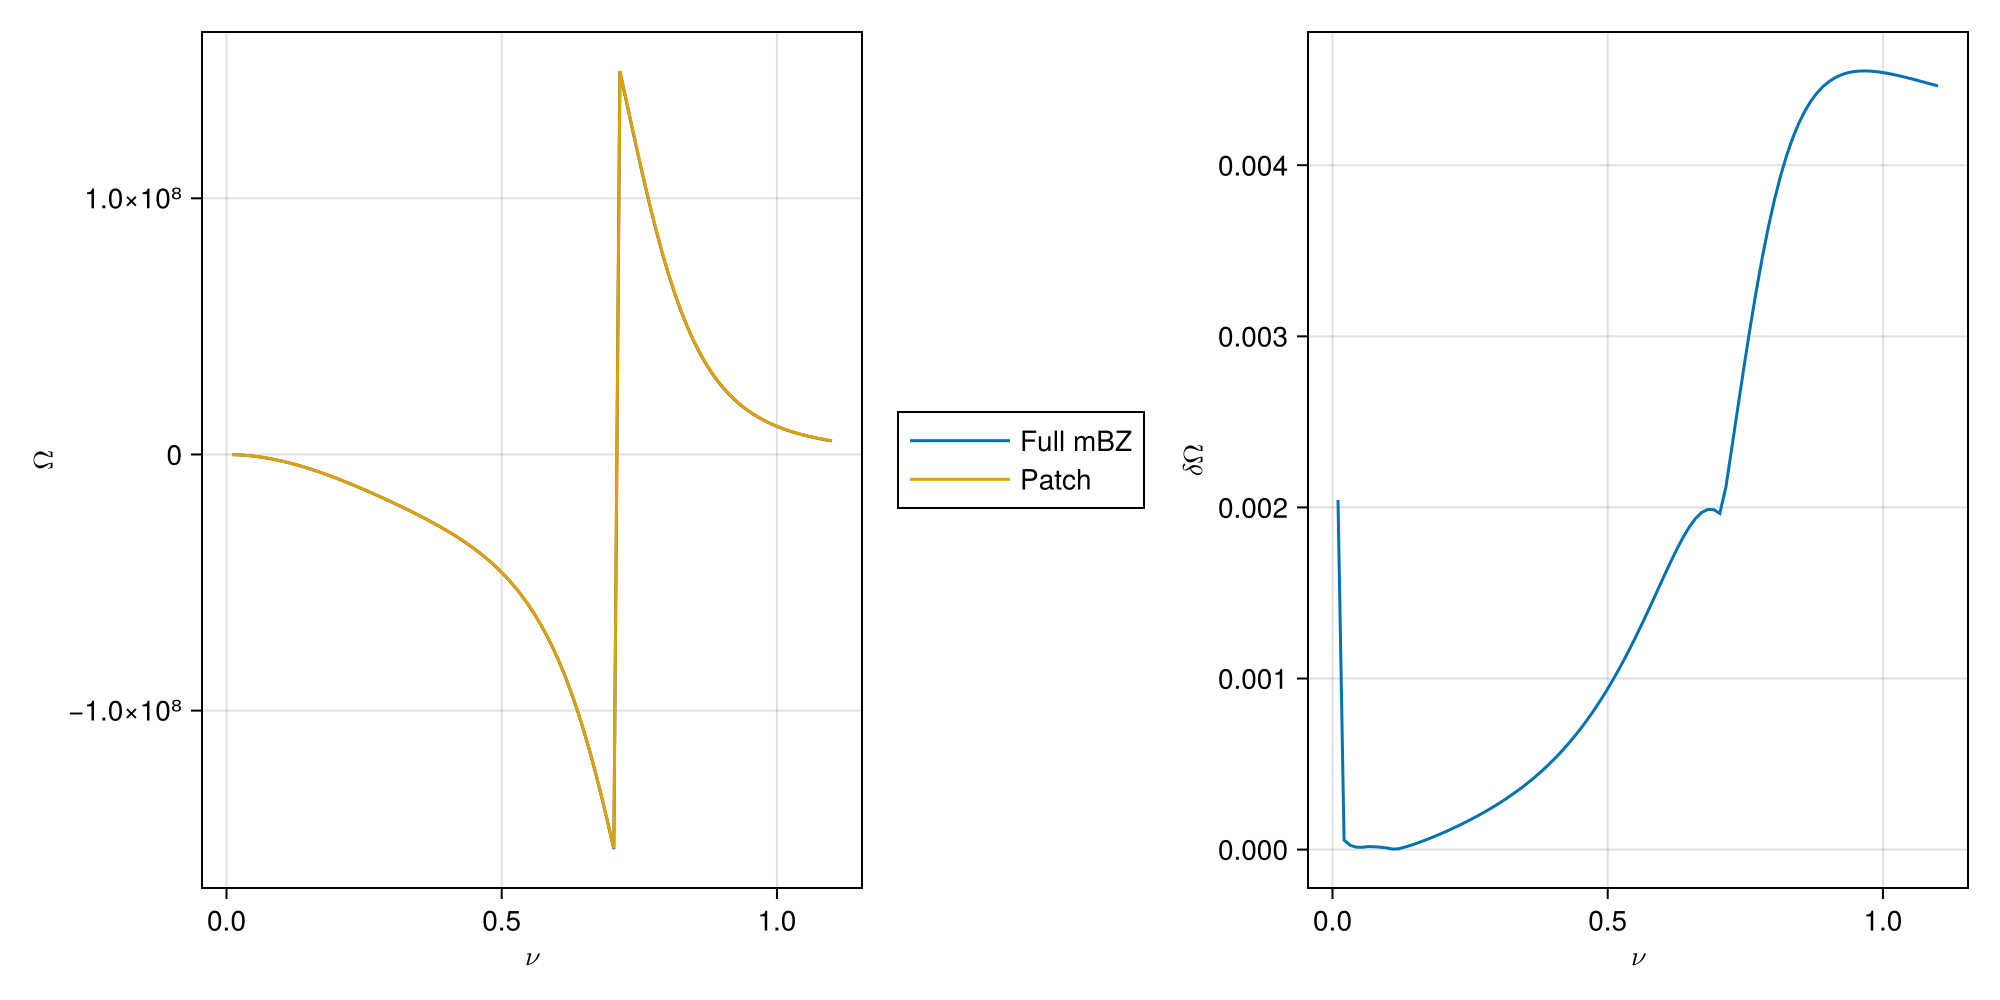

In [909]:
kappa = 1
V = -0.001
Nl = 3
spacing = 10^(-4)
shells = 8
compare_origin_nu_linear_shells(spacing, kappa, V, Nl, shells)

# Comparison across patch

In [887]:
function mBZ_berry_linear_comp(pd, Nl, nu, kappa, V, shells)
    spacing = 10^(-3) * (kappa / pd)
    fig = Figure(size=(3800, 1500), fontsize=50, fonts = (; regular = "italic", weird = "bold"))
    ax1 = Axis(fig[1, 1], title = L"\Omega^\text{3p} \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")
    ax2 = Axis(fig[1, 3], title = L"\Omega^\text{mBZ} \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")
    ax3 = Axis(fig[1, 5], title = L"\delta \Omega \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")

    # grid = make_hex([0, 0], kappa, kappa / pd)

    kappa_1 = kappa * [1, 0]

    shift = 0.5 * range(-1, 1, 10^2)

    kx_list = kappa_1[1] * ones(10^2) .+ shift
    ky_list = kappa_1[2] * ones(10^2) .+ shift

    grid = mesh_grid(kx_list, ky_list, Float64)

    patch_grid = mesh_grid(shift, shift, Float64)

    delta = V/2 * rmg_delta_linear(kappa, nu, Nl)
    alpha = V/2 * rmg_alpha_linear(kappa, nu, Nl)
    vF = 3 * kappa^2

    patch_bc = rmg_patch_bc(patch_grid, spacing, Nl, nu, kappa, vF, delta, alpha)

    mBZ_bc = rmg_mBZ_shells_bc_linear(grid, spacing, Nl, nu, kappa, V, shells)
    
    # patch
    zmax, zmin = maximum(patch_bc), minimum(patch_bc)
    zabs = maximum([abs(zmax), abs(zmin)])
    patch_levels = range(-zabs, zabs, 10)
    tr1 = tricontourf!(ax1, grid[:, 1], grid[:, 2], patch_bc, colormap = :RdBu, levels = patch_levels)
    cb1 = Colorbar(fig[1, 2], tr1)

   # mBZ
   zmax, zmin = maximum(mBZ_bc), minimum(mBZ_bc)
   zabs = maximum([abs(zmax), abs(zmin)])
   mBZ_levels = range(-zabs, zabs, 10)
   tr1 = tricontourf!(ax2, grid[:, 1], grid[:, 2], mBZ_bc, colormap = :RdBu, levels = mBZ_levels)
   cb1 = Colorbar(fig[1, 4], tr1)

   # error
   error = abs.((patch_bc .- mBZ_bc))
   tr1 = tricontourf!(ax3, grid[:, 1], grid[:, 2], error, colormap = :RdBu)
   cb1 = Colorbar(fig[1, 6], tr1)
   
   fig
end

mBZ_berry_linear_comp (generic function with 1 method)

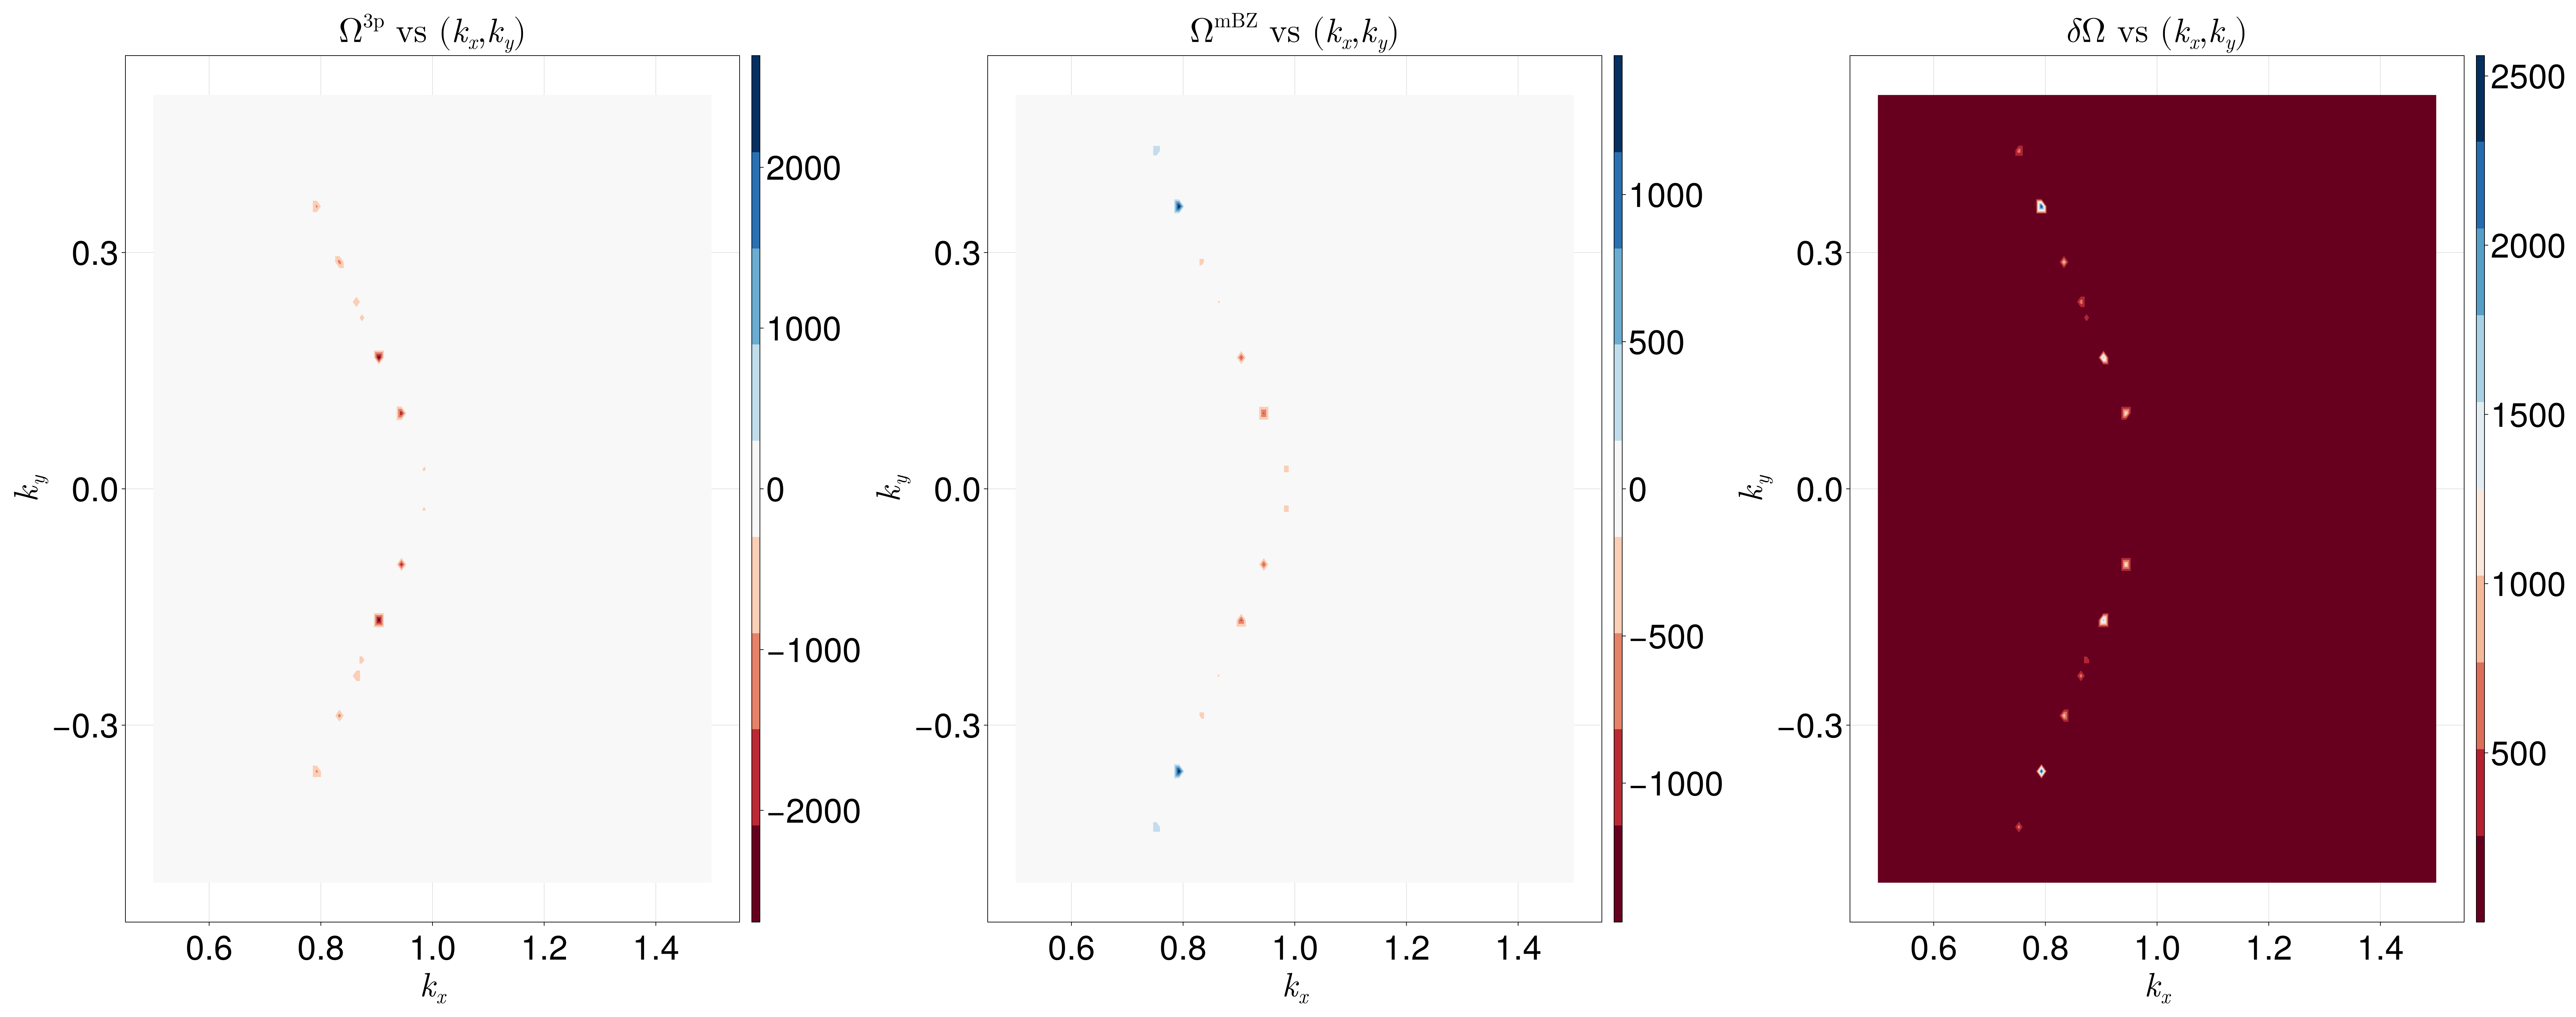

In [898]:
pd = 100
Nl = 3
nu = 0.8
kappa = 1
V = -0.01
shells = 2
mBZ_berry_linear_comp(pd, Nl, nu, kappa, V, shells)

In [893]:
function mBZ_berry_uniform_comp(pd, Nl, nu, kappa, V, shells)
    spacing = 10^(-3) * (kappa / pd)
    fig = Figure(size=(3800, 1500), fontsize=50, fonts = (; regular = "italic", weird = "bold"))
    ax1 = Axis(fig[1, 1], title = L"\Omega^\text{3p} \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")
    ax2 = Axis(fig[1, 3], title = L"\Omega^\text{mBZ} \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")
    ax3 = Axis(fig[1, 5], title = L"\delta \Omega \text{ vs } (k_x, k_y)", xlabel = L"k_x", ylabel = L"k_y")

    # grid = make_hex([0, 0], kappa, kappa / pd)

    kappa_1 = kappa * [1, 0]

    shift = 0.5 * range(-1, 1, 10^2)

    kx_list = kappa_1[1] * ones(10^2) .+ shift
    ky_list = kappa_1[2] * ones(10^2) .+ shift

    grid = mesh_grid(kx_list, ky_list, Float64)

    patch_grid = mesh_grid(shift, shift, Float64)

    delta = V/2 * rmg_delta_all(kappa, nu, Nl)
    alpha = V/2 * rmg_alpha_all(kappa, nu, Nl)
    vF = 3 * kappa^2

    patch_bc = rmg_patch_bc(patch_grid, spacing, Nl, nu, kappa, vF, delta, alpha)

    mBZ_bc = rmg_mBZ_shells_bc(grid, spacing, Nl, nu, kappa, V, shells)
    
    # patch
    zmax, zmin = maximum(patch_bc), minimum(patch_bc)
    zabs = maximum([abs(zmax), abs(zmin)])
    patch_levels = range(-zabs, zabs, 10)
    tr1 = tricontourf!(ax1, grid[:, 1], grid[:, 2], patch_bc, colormap = :RdBu, levels = patch_levels)
    cb1 = Colorbar(fig[1, 2], tr1)

   # mBZ
   zmax, zmin = maximum(mBZ_bc), minimum(mBZ_bc)
   zabs = maximum([abs(zmax), abs(zmin)])
   mBZ_levels = range(-zabs, zabs, 10)
   tr1 = tricontourf!(ax2, grid[:, 1], grid[:, 2], mBZ_bc, colormap = :RdBu, levels = mBZ_levels)
   cb1 = Colorbar(fig[1, 4], tr1)

   # error
   error = abs.((patch_bc .- mBZ_bc))
   tr1 = tricontourf!(ax3, grid[:, 1], grid[:, 2], error, colormap = :RdBu)
   cb1 = Colorbar(fig[1, 6], tr1)
   
   fig
end

mBZ_berry_uniform_comp (generic function with 1 method)

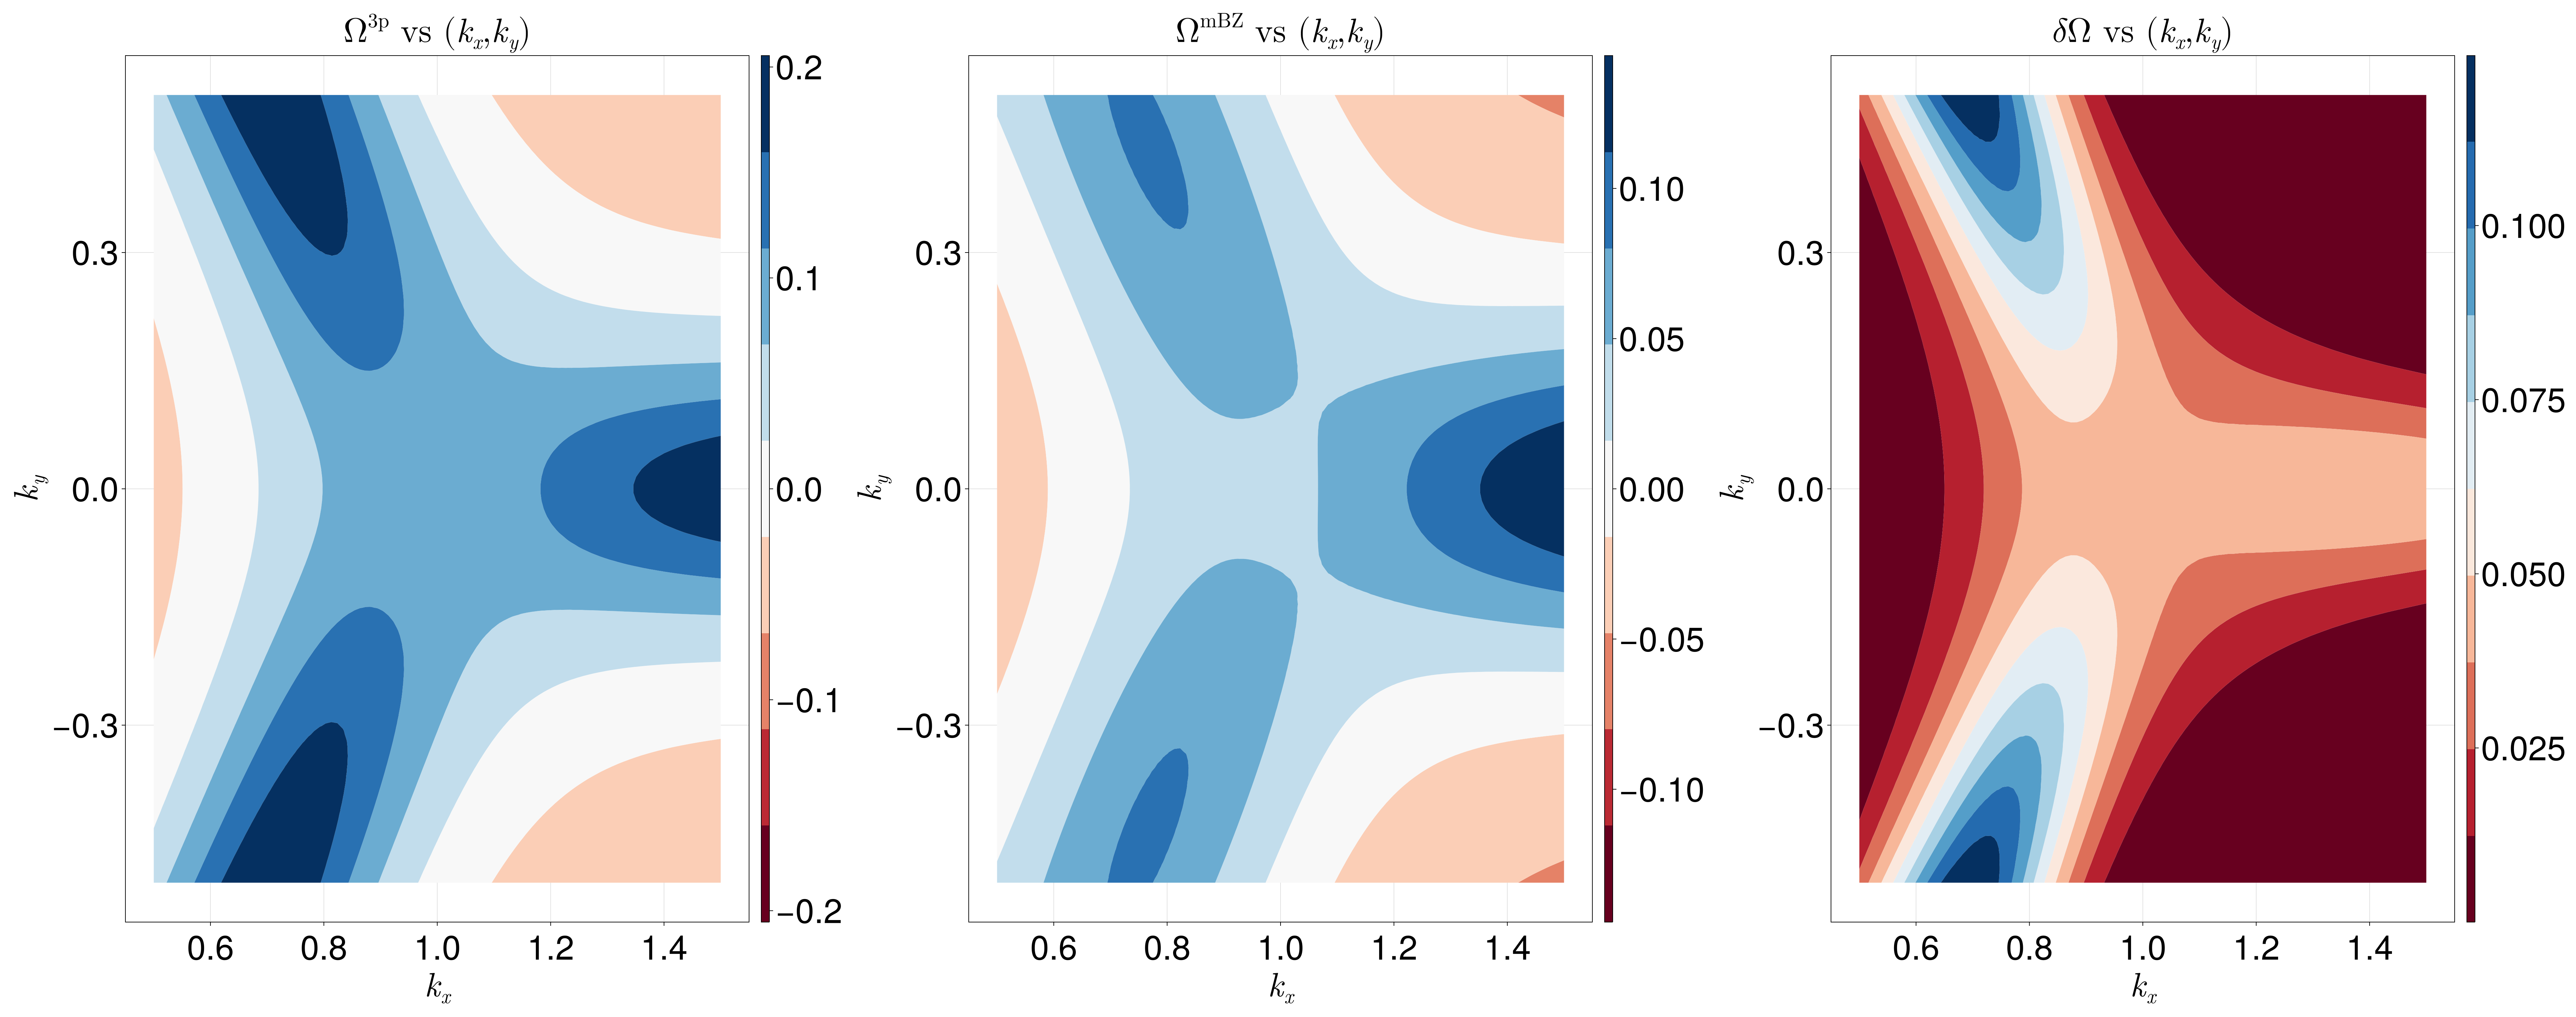

In [897]:
pd = 100
Nl = 3
nu = 0.2
kappa = 1
V = -1
shells = 1
mBZ_berry_uniform_comp(pd, Nl, nu, kappa, V, shells)

# Band Structure

Here we're going to be calculating the band structure of the full mBZ Hamiltonian

In [559]:
function mBZ_band_structure(Nl, nu, kappa, V, shells)
    k_list = range(-2 * kappa, 2 * kappa, 10^2)
    mBZ_count = num_mBZ(shells)
    energies = Array{Float64}(undef, length(k_list), length(k_list), mBZ_count)
    for i in 1:length(k_list)
        kx = k_list[i]
        for j in 1:length(k_list)
            ky = k_list[j]
            ham = rmg_ham_mBZ_shells([kx, ky], Nl, nu, kappa, V, shells)
            energies[i, j, :] = real.(eigvals(Hermitian(ham)))
        end
    end
    linear_energies = Array{Float64}(undef, length(k_list), length(k_list), mBZ_count)
    for i in 1:length(k_list)
        kx = k_list[i]
        for j in 1:length(k_list)
            ky = k_list[j]
            ham = rmg_ham_mBZ_shells_linear([kx, ky], Nl, nu, kappa, V, shells)
            linear_energies[i, j, :] = real.(eigvals(Hermitian(ham)))
        end
    end
    fig = Figure(size=(2200, 3200), fontsize=50)
    ax = Axis3(fig[1, 1]; xlabel=L"k_x", ylabel=L"k_y", zlabel="", title=L" \epsilon_\text{uniform}(k_x, k_y) \text{ vs } (k_x, k_y)", 
    titlegap = 1)
    ax.elevation[] = pi/9

    index1 = 1
    index2 = 2

    # Now we need to properly set limits and plot the actual bands
    # I think 2 bands is usually just right for comparison
    zmin = minimum(vcat(energies[:, :, index1], energies[:, :, index2]))
    zmax = maximum(vcat(energies[:, :, index1], energies[:, :, index2]))
    zabs = maximum(abs.([zmin, zmax]))

    tr = surface!(ax, k_list, k_list, energies[:, :, index1], colormap = :RdBu, colorrange = (-zabs, zabs))
    tr = surface!(ax, k_list, k_list, energies[:, :, index2], colormap = :RdBu, colorrange = (-zabs, zabs))

    cb1 = Colorbar(fig[1, 2], tr)

    

    zmin = minimum(vcat(linear_energies[:, :, index1], linear_energies[:, :, index2]))
    zmax = maximum(vcat(linear_energies[:, :, index1], linear_energies[:, :, index2]))
    zabs = maximum(abs.([zmin, zmax]))
    
    ax1 = Axis3(fig[2, 1]; xlabel=L"k_x", ylabel=L"k_y", zlabel="", title=L" \epsilon_\text{linear}(k_x, k_y) \text{ vs } (k_x, k_y)")
    ax1.elevation[] = pi/9

    tr = surface!(ax1, k_list, k_list, linear_energies[:, :, index1], colormap = :RdBu, colorrange = (-zabs, zabs))
    tr = surface!(ax1, k_list, k_list, linear_energies[:, :, index2], colormap = :RdBu, colorrange = (-zabs, zabs))

    cb1 = Colorbar(fig[2, 2], tr)
    # surface!(ax, k_list, k_list, energies[:, :, 2], axis=(type=Axis3,))
    # surface!(ax, k_list, k_list, energies[:, :, 3], axis=(type=Axis3,))

    fig
end

mBZ_band_structure (generic function with 2 methods)

In [722]:
Nl = 3
nu = 0.5
kappa = 1
V = -0.7
shells = 8
mBZ_band_structure(Nl, nu, kappa, V, shells)

InterruptException: InterruptException:

In [899]:
function mBZ_band_structure_nu(q, Nl, kappa, V, shells)
    nu_list = range(0.1, 0.2, 10^2)
    mBZ_count = num_mBZ(shells)
    energies = Array{Float64}(undef, length(nu_list), mBZ_count)
    for i in 1:length(nu_list)
        nu = nu_list[i]
        ham = rmg_ham_mBZ_shells(q, Nl, nu, kappa, V, shells)
        energies[i, :] = real.(eigvals(Hermitian(ham)))
    end
    linear_energies = Array{Float64}(undef, length(nu_list), mBZ_count)
    for i in 1:length(nu_list)
        nu = nu_list[i]
        ham = rmg_ham_mBZ_shells_linear(q, Nl, nu, kappa, V, shells)
        linear_energies[i, :] = real.(eigvals(Hermitian(ham)))
    end
    fig = Figure(size=(3300, 1500), fontsize=50)
    ax = Axis(fig[1, 1]; xlabel=L"\nu", ylabel=L"\epsilon_\text{uniform}", title=L" \epsilon_\text{uniform} \text{ vs } \nu")

    index1 = 1
    index2 = 2
    
    lines!(ax, nu_list, energies[:, index1], label = L"1")
    lines!(ax, nu_list, energies[:, index2], label = L"2")


    ax1 = Axis(fig[1, 2]; xlabel=L"\nu", ylabel=L"\epsilon_\text{linear}", title=L" \epsilon_\text{linear} \text{ vs } \nu")
    
    lines!(ax1, nu_list, linear_energies[:, index1], label = L"1")
    lines!(ax1, nu_list, linear_energies[:, index2], label = L"2")

    fig[1, 3] = Legend(fig, ax1, patchsize = (50, 10), framevisible = true)

    fig
end

mBZ_band_structure_nu (generic function with 1 method)

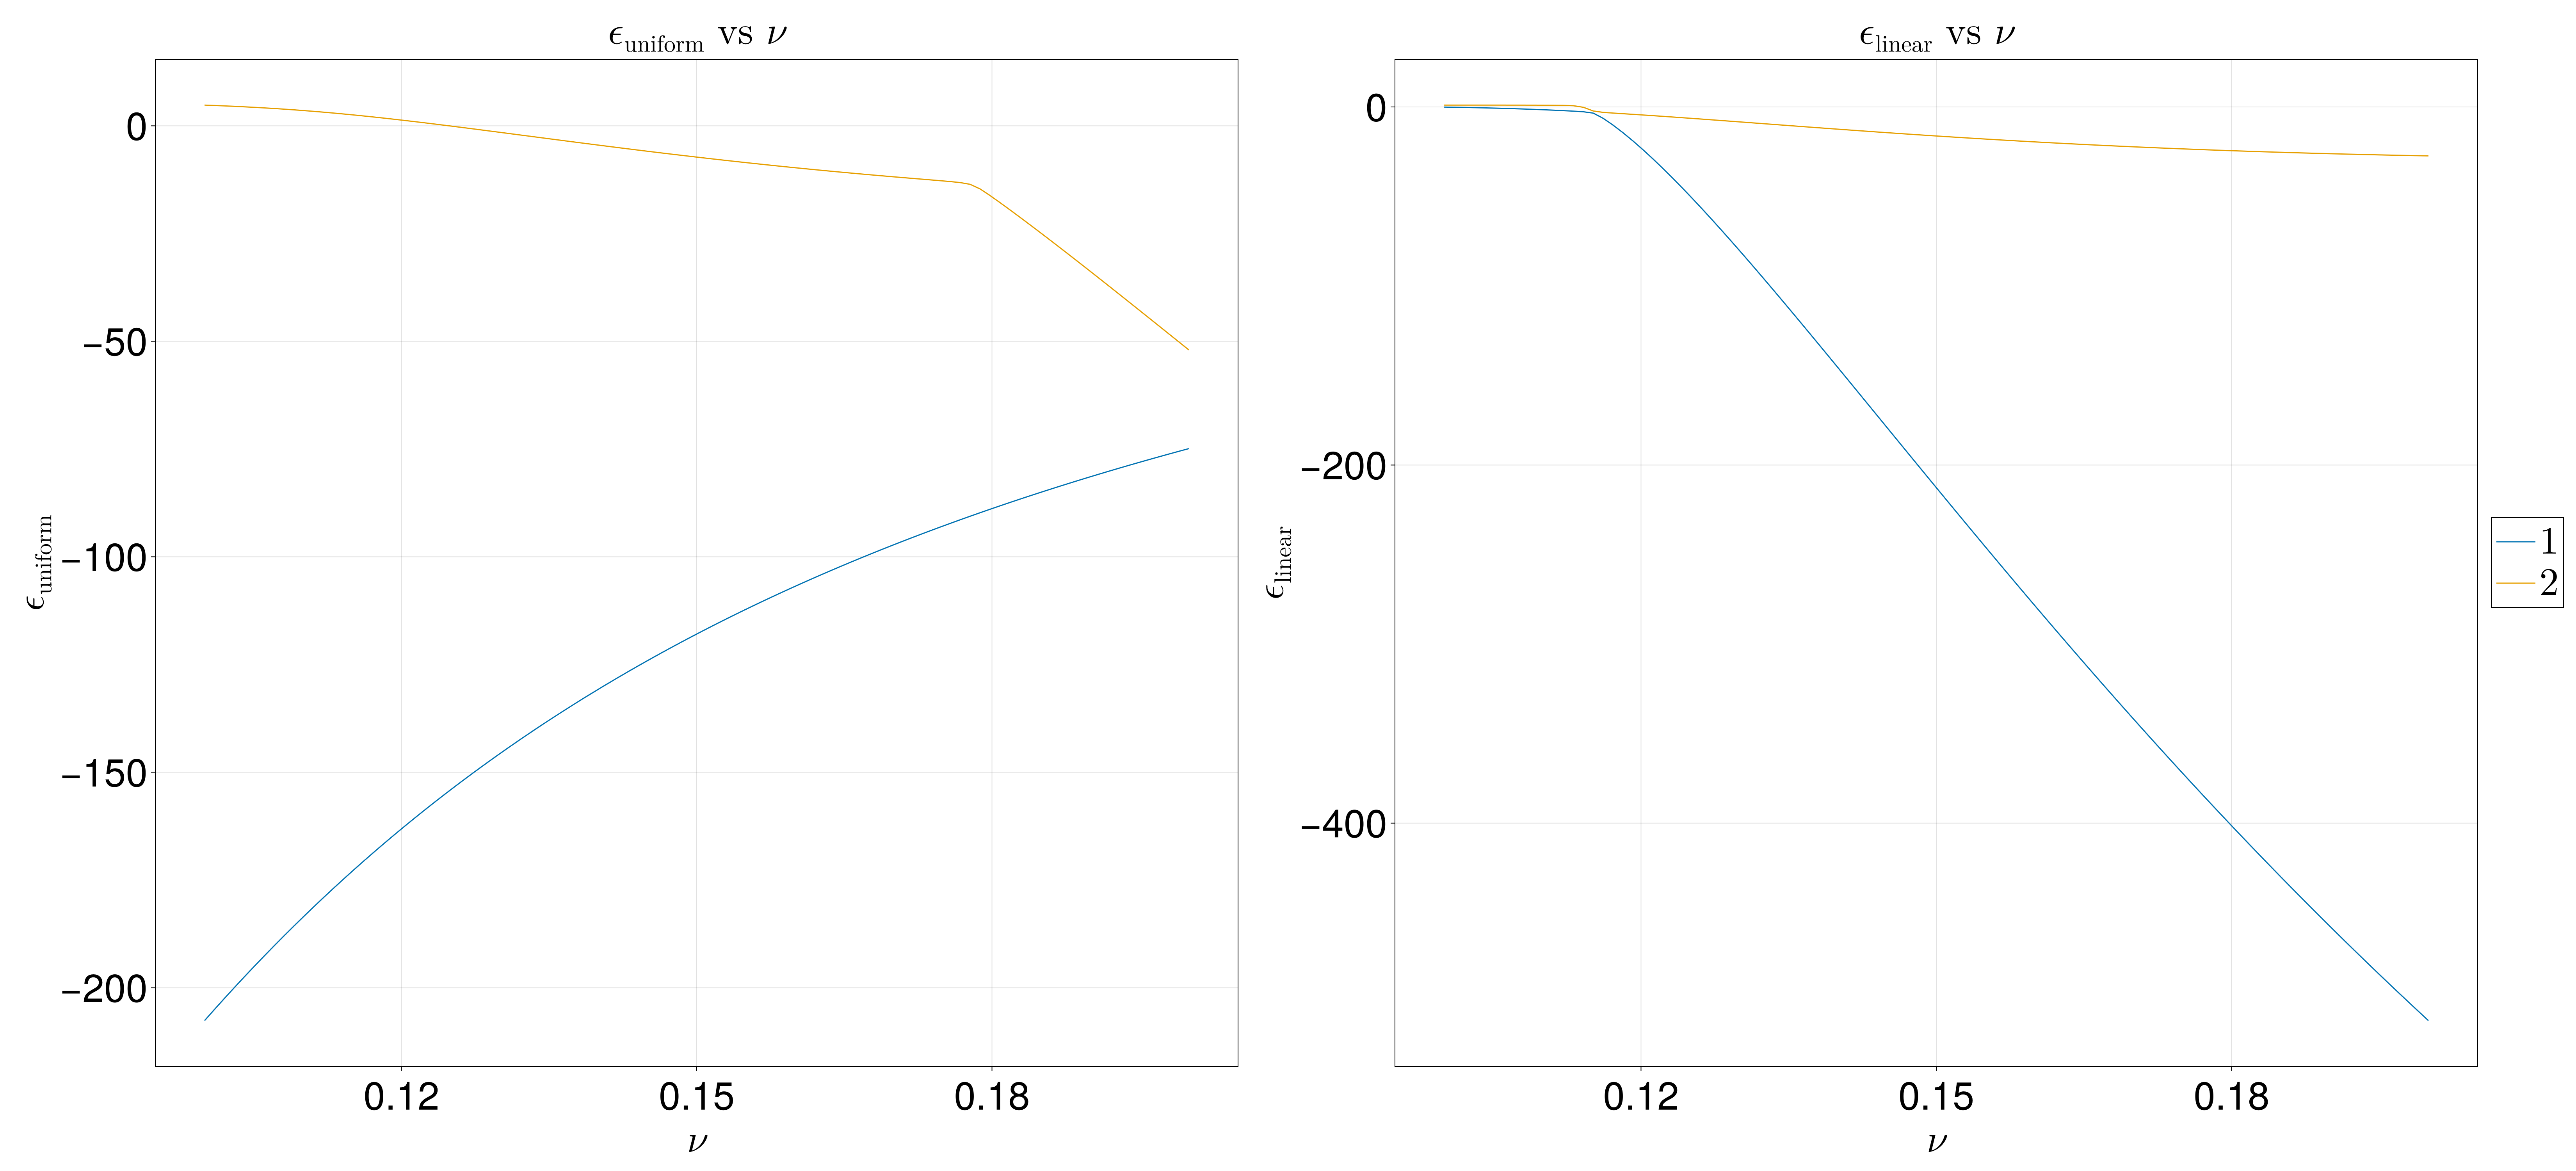

In [904]:
Nl = 3
kappa = 1
V = -10
shells = 11
q = kappa * [1, 0]
mBZ_band_structure_nu(q, Nl, kappa, V, shells)

# A few comments

When we are working in the strong moire regime $|V| \gg 1$, we can assume (given a sufficient number of mBZ shells) that the eigenvectors are periodic within a single mBZ. This implies that the Chern number is quantized within a single mBZ. 

However, when working in some intermediate regime, this is not the case. There is not yet a ``hard'' mBZ imposed, so the Berry curvature is smeared across k-space. As a result, Chern number can only be quantized over all of k-space.

# Number of shells to enforce periodic eigenstates

We need to check for periodicity of eigenvectors across mBZ. Need to ensure Chern number is quantized properly

In [667]:
function uniform_periodicity_check(Nl, nu, kappa, V, shells, index)
    k_list = range(0, kappa, 10^2)
    theta_list = range(-pi, pi, 10^2)
    k_overlaps = Array{Float64}(undef, length(k_list), 3)
    theta_overlaps = Array{Float64}(undef, length(theta_list), 3)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    for j in 1:length(k_list)
        kx = k_list[j] * cos(4*pi/7)
        ky = k_list[j] * sin(4*pi/7)

        ham1 = rmg_ham_mBZ_shells([kx, ky], Nl, nu, kappa, V, shells)
        vector1 = gauge_fix(normalize(eigvecs(Hermitian(ham1))[:, index]))

        ham2 = rmg_ham_mBZ_shells(g1 .+ [kx, ky], Nl, nu, kappa, V, shells)
        vector2 = gauge_fix(normalize(eigvecs(Hermitian(ham2))[:, index]))

        ham3 = rmg_ham_mBZ_shells(g2 .+ [kx, ky], Nl, nu, kappa, V, shells)
        vector3 = gauge_fix(normalize(eigvecs(Hermitian(ham3))[:, index]))

        ham4 = rmg_ham_mBZ_shells(g2 .- g1 .+ [kx, ky], Nl, nu, kappa, V, shells)
        vector4 = gauge_fix(normalize(eigvecs(Hermitian(ham4))[:, index]))

        k_overlaps[j, 1] = abs(dot(vector1, vector2))
        k_overlaps[j, 2] = abs(dot(vector1, vector3))
        k_overlaps[j, 3] = abs(dot(vector1, vector4))
    end

    for j in 1:length(theta_list)
            kx = 0.43 * cos(theta_list[j])
            ky = 0.43 * sin(theta_list[j])

            ham1 = rmg_ham_mBZ_shells([kx, ky], Nl, nu, kappa, V, shells)
            vector1 = gauge_fix(normalize(eigvecs(Hermitian(ham1))[:, index]))

            ham2 = rmg_ham_mBZ_shells(g1 .+ [kx, ky], Nl, nu, kappa, V, shells)
            vector2 = gauge_fix(normalize(eigvecs(Hermitian(ham2))[:, index]))

            ham3 = rmg_ham_mBZ_shells(g2 .+ [kx, ky], Nl, nu, kappa, V, shells)
            vector3 = gauge_fix(normalize(eigvecs(Hermitian(ham3))[:, index]))

            ham4 = rmg_ham_mBZ_shells(g2 .- g1 .+ [kx, ky], Nl, nu, kappa, V, shells)
            vector4 = gauge_fix(normalize(eigvecs(Hermitian(ham4))[:, index]))

            theta_overlaps[j, 1] = abs(dot(vector1, vector2))
            theta_overlaps[j, 2] = abs(dot(vector1, vector3))
            theta_overlaps[j, 3] = abs(dot(vector1, vector4))
        end
    
    P = Figure()
    ax1 = Axis(P[1, 1], title = L"f", xlabel = L"|k|", ylabel = L"\text{overlap}")
    lines!(ax1, k_list, k_overlaps[:, 1], label = L"g_1")
    lines!(ax1, k_list, k_overlaps[:, 2], label = L"g_2")
    lines!(ax1, k_list, k_overlaps[:, 3], label = L"g_3")

    ax2 = Axis(P[1, 2], title = L"f", xlabel = L"\theta", ylabel = L"\text{overlap}")
    lines!(ax2, theta_list, theta_overlaps[:, 1], label = L"g_1")
    lines!(ax2, theta_list, theta_overlaps[:, 2], label = L"g_2")
    lines!(ax2, theta_list, theta_overlaps[:, 3], label = L"g_3")

    P[1, 3] = Legend(P, ax1, patchsize = (50, 10), framevisible = true)

    P
end

uniform_periodicity_check (generic function with 1 method)

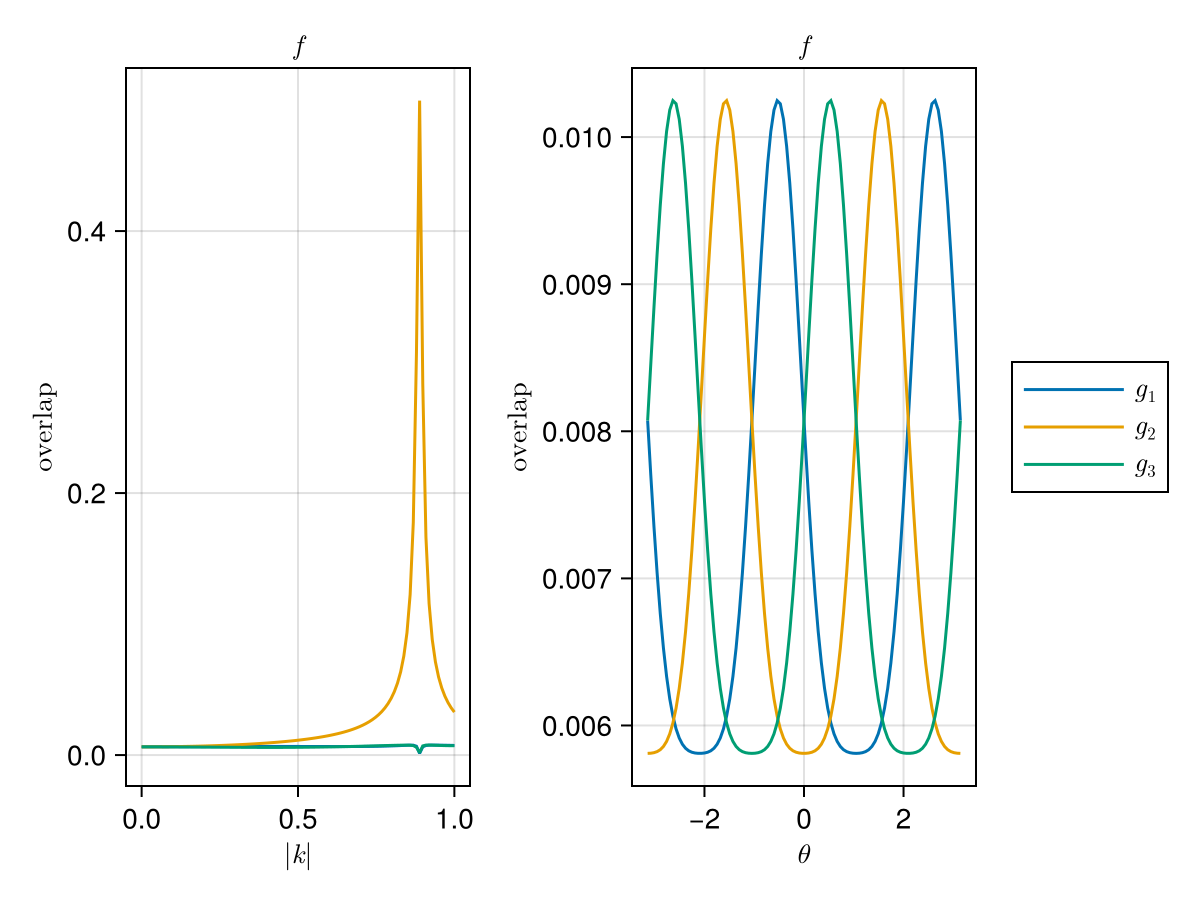

In [669]:
Nl = 3
nu = 0.9
kappa = 1
V = 0.1
shells = 15
index = 1
uniform_periodicity_check(Nl, nu, kappa, V, shells, index)

# Chern Number

In [284]:
function uniform_chern(Nl, nu, kappa, V, shells, index, spacing)
    grid = make_hex([0, 0], kappa, spacing)
    total_bc = sum(rmg_mBZ_shells_bc(grid, spacing, Nl, nu, kappa, V, shells))
    return 1/(2 * pi) * area(spacing * sqrt(2), 4) * total_bc
end

uniform_chern (generic function with 1 method)

In [536]:
function linear_chern(Nl, nu, kappa, V, shells, index, spacing)
    grid = make_hex([0, 0], kappa, spacing)
    total_bc = sum(rmg_mBZ_shells_bc_linear(grid, spacing, Nl, nu, kappa, V, shells))
    return 1/(2 * pi) * area(spacing * sqrt(2), 4) * total_bc
end

linear_chern (generic function with 1 method)

In [529]:
function uniform_contour_chern(Nl, nu, kappa, V, shells, index, spacing)
    contour = hex_outline([0, 0], kappa, spacing)
    mom_list = partitions_to_momenta(shells, kappa)
    
    states = Array{ComplexF64}(undef, size(contour, 1), size(mom_list, 1))

    num_vertices = size(contour, 1)

    spinors = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1), Nl)
    grounds = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1))

    for j in 1:num_vertices
        kx, ky = contour[j, :]
        ham = rmg_ham_mBZ_shells([kx, ky], Nl, nu, kappa, V, shells)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, 1]))

        for m in 1:size(mom_list, 1)
            momentum = mom_list[m, :] .+ [kx, ky]
            sor = normalize(rmg_spinor(Nl, nu, momentum))
            spinors[j, m, :] = gauge_fix(sor)
        end
    end
    P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :])
            P *= temp / abs(temp)
        else
            temp = spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :])
            P *= temp / abs(temp)
        end
    end
    if abs(imag(P)) < 10^(-16)
        return -1/(2*pi) * (angle(real(P))) / area(spacing * sqrt(2), num_vertices)
    else
        return -1/(2*pi) * angle(P) / area(spacing * sqrt(2), num_vertices)
    end
end

uniform_contour_chern (generic function with 1 method)

In [531]:
function linear_contour_chern(Nl, nu, kappa, V, shells, index, spacing)
    contour = hex_outline([0, 0], kappa, spacing)
    mom_list = partitions_to_momenta(shells, kappa)
    
    states = Array{ComplexF64}(undef, size(contour, 1), size(mom_list, 1))

    num_vertices = size(contour, 1)

    spinors = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1), Nl)
    grounds = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1))

    for j in 1:num_vertices
        kx, ky = contour[j, :]
        ham = rmg_ham_mBZ_shells_linear([kx, ky], Nl, nu, kappa, V, shells)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, 1]))

        for m in 1:size(mom_list, 1)
            momentum = mom_list[m, :] .+ [kx, ky]
            sor = normalize(rmg_spinor(Nl, nu, momentum))
            spinors[j, m, :] = gauge_fix(sor)
        end
    end
    P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :])
            P *= temp / abs(temp)
        else
            temp = spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :])
            P *= temp / abs(temp)
        end
    end
    if abs(imag(P)) < 10^(-16)
        return -1/(2*pi) * (angle(real(P))) / area(spacing * sqrt(2), num_vertices)
    else
        return -1/(2*pi) * angle(P) / area(spacing * sqrt(2), num_vertices)
    end
end

linear_contour_chern (generic function with 1 method)

In [664]:
Nl = 3
nu = 0.9
kappa = 1
V = -1
shells = 3
index = 1
println(linear_contour_chern(Nl, nu, kappa, V, shells, index, 0.1))

-0.007594651145864559


In [670]:
display(uniform_chern(Nl, nu, kappa, V, shells, index, 0.1))

InterruptException: InterruptException:

# Chern number (intermediate regime)

In [671]:
function make_circle(n_V, R)
    points = Array{Float64}(undef, n_V, 2)
    for j in 1:n_V
        points[j, 1] = R * cos(2 * pi * (j - 1) / n_V)
        points[j, 2] = R * sin(2 * pi * (j - 1) / n_V)
    end
    return points
end

make_circle (generic function with 1 method)

In [672]:
function uniform_contour_chern_circle(Nl, nu, kappa, V, shells, index, n_V, R)
    contour = make_circle(n_V, R)
    mom_list = partitions_to_momenta(shells, kappa)
    
    states = Array{ComplexF64}(undef, size(contour, 1), size(mom_list, 1))

    num_vertices = size(contour, 1)

    spinors = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1), Nl)
    grounds = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1))

    for j in 1:num_vertices
        kx, ky = contour[j, :]
        ham = rmg_ham_mBZ_shells([kx, ky], Nl, nu, kappa, V, shells)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, 1]))

        for m in 1:size(mom_list, 1)
            momentum = mom_list[m, :] .+ [kx, ky]
            sor = normalize(rmg_spinor(Nl, nu, momentum))
            spinors[j, m, :] = gauge_fix(sor)
        end
    end
    P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :])
            P *= temp / abs(temp)
        else
            temp = spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :])
            P *= temp / abs(temp)
        end
    end
    if abs(imag(P)) < 10^(-16)
        return -1/(2*pi) * (angle(real(P))) / area(spacing * sqrt(2), num_vertices)
    else
        return -1/(2*pi) * angle(P) / area(spacing * sqrt(2), num_vertices)
    end
end

uniform_contour_chern_circle (generic function with 1 method)

In [699]:
function linear_contour_chern_circle(Nl, nu, kappa, V, shells, index, n_V, R)
    contour = make_circle(n_V, R)
    mom_list = partitions_to_momenta(shells, kappa)
    
    states = Array{ComplexF64}(undef, size(contour, 1), size(mom_list, 1))

    num_vertices = size(contour, 1)

    spinors = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1), Nl)
    grounds = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1))

    for j in 1:num_vertices
        kx, ky = contour[j, :]
        ham = rmg_ham_mBZ_shells_linear([kx, ky], Nl, nu, kappa, V, shells)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, 1]))

        for m in 1:size(mom_list, 1)
            momentum = mom_list[m, :] .+ [kx, ky]
            sor = normalize(rmg_spinor(Nl, nu, momentum))
            spinors[j, m, :] = gauge_fix(sor)
        end
    end
    P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :])
            P *= temp / abs(temp)
        else
            temp = spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :])
            P *= temp / abs(temp)
        end
    end
    if abs(imag(P)) < 10^(-16)
        return -1/(2*pi) * (angle(real(P))) / area(spacing * sqrt(2), num_vertices)
    else
        return -1/(2*pi) * angle(P) / area(spacing * sqrt(2), num_vertices)
    end
end

linear_contour_chern_circle (generic function with 1 method)

In [718]:
function uni_rad_conv(Nl, nu, kappa, V, shells, index, n_V)
    R_list = kappa * range(1, 100, 10^2)
    c_list = Array{Float64}(undef, length(R_list))
    for j in 1:length(R_list)
        R = R_list[j]
        c_list[j] = uniform_contour_chern_circle(Nl, nu, kappa, V, shells, index, n_V, R)
    end
    P = Figure()
    ax1 = Axis(P[1, 1], title = L"f", xlabel = L"R", ylabel = L"C")
    lines!(ax1, R_list, c_list)
    P
end

uni_rad_conv (generic function with 1 method)

In [874]:
function lin_rad_conv(Nl, nu, kappa, V, shells, index, n_V)
    R_list = kappa * range(1, 500, 10^2)
    c_list = Array{Float64}(undef, length(R_list))
    for j in 1:length(R_list)
        R = R_list[j]
        c_list[j] = linear_contour_chern_circle(Nl, nu, kappa, V, shells, index, n_V, R)
    end
    P = Figure()
    ax1 = Axis(P[1, 1], title = L"f", xlabel = L"R", ylabel = L"C")
    lines!(ax1, R_list, c_list)
    P
end

lin_rad_conv (generic function with 1 method)

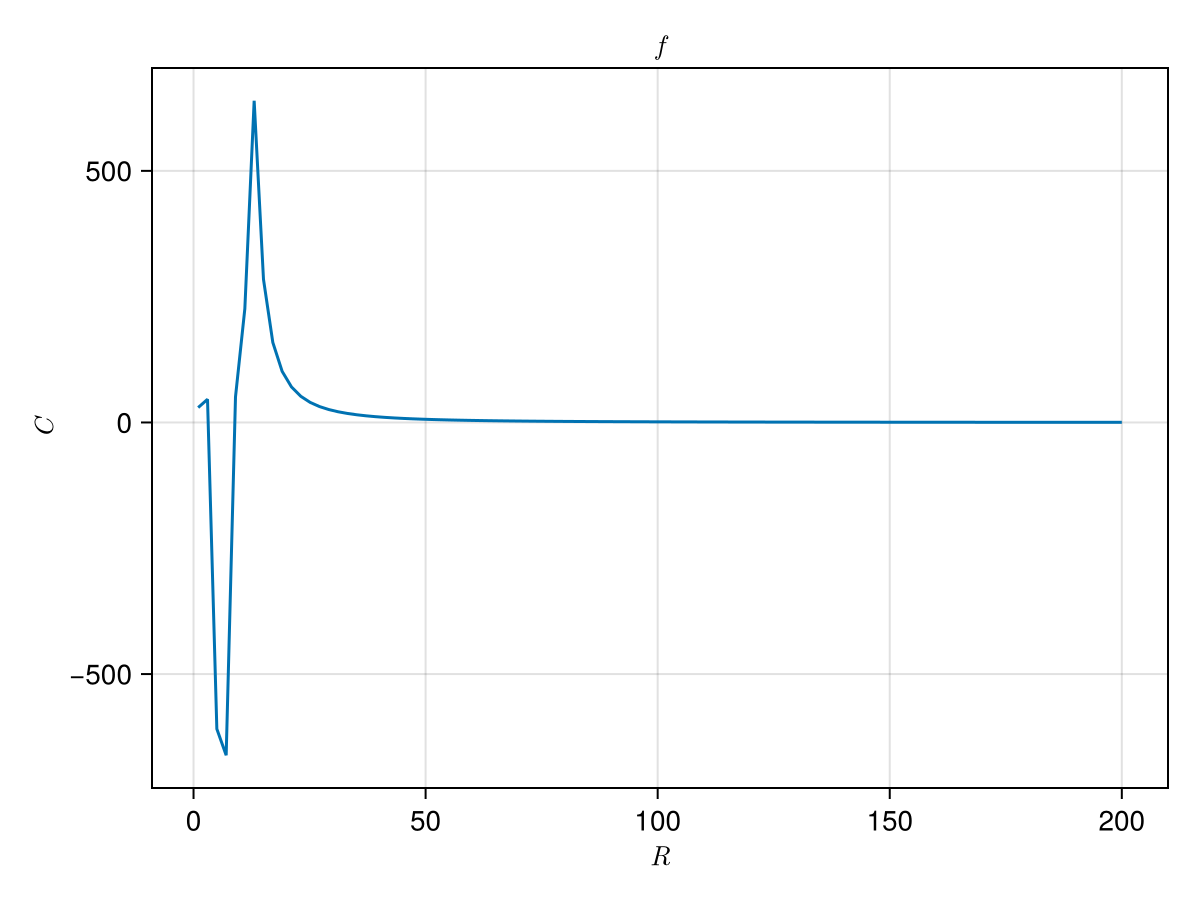

In [698]:
Nl = 3
nu = 0.4
kappa = 1
V = 0.01
shells = 3
index = 1
n_V = 600
uni_rad_conv(Nl, nu, kappa, V, shells, index, n_V)

In [720]:
Nl = 3
nu = 0.2
kappa = 1
V = -0.7
shells = 8
index = 1
n_V = 600
lin_rad_conv(Nl, nu, kappa, V, shells, index, n_V)

InterruptException: InterruptException:

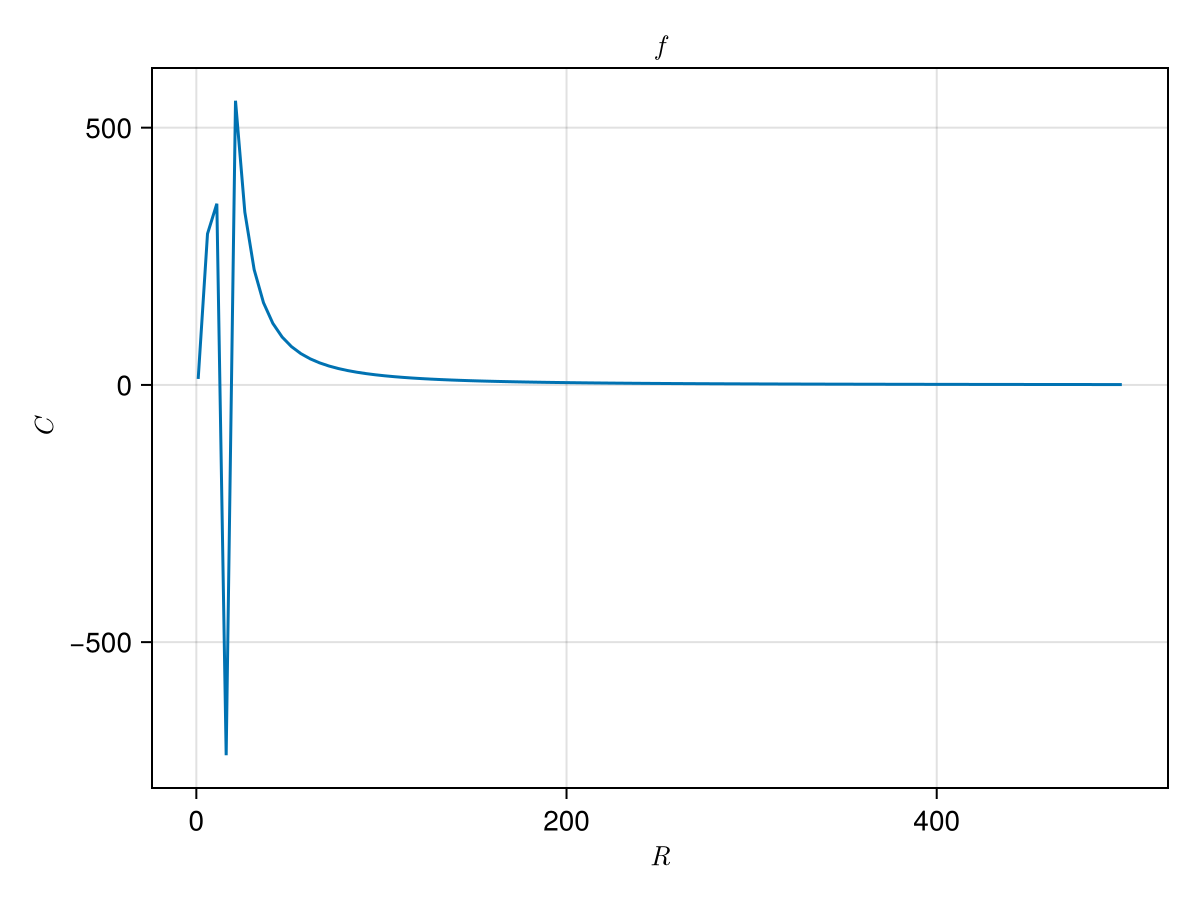

In [910]:
Nl = 3
nu = 0.1
kappa = 1
V = -0.01
shells = 1
index = 1
n_V = 600
lin_rad_conv(Nl, nu, kappa, V, shells, index, n_V)

In [881]:
display(linear_contour_chern_circle(Nl, nu, kappa, V, 1, index, n_V, 170))

6.210464492042346

In [914]:
uniform_chern(Nl, nu, kappa, V, 2, index, 10^(-2))

-0.020795501188283903

In [926]:
nu = 0.6
V = 10

10

In [928]:
uniform_chern(Nl, nu, kappa, V, 2, index, 10^(-2))

2.132010576874483

In [929]:
uniform_chern(Nl, nu, kappa, V, 3, index, 10^(-2))

2.2160198667722755

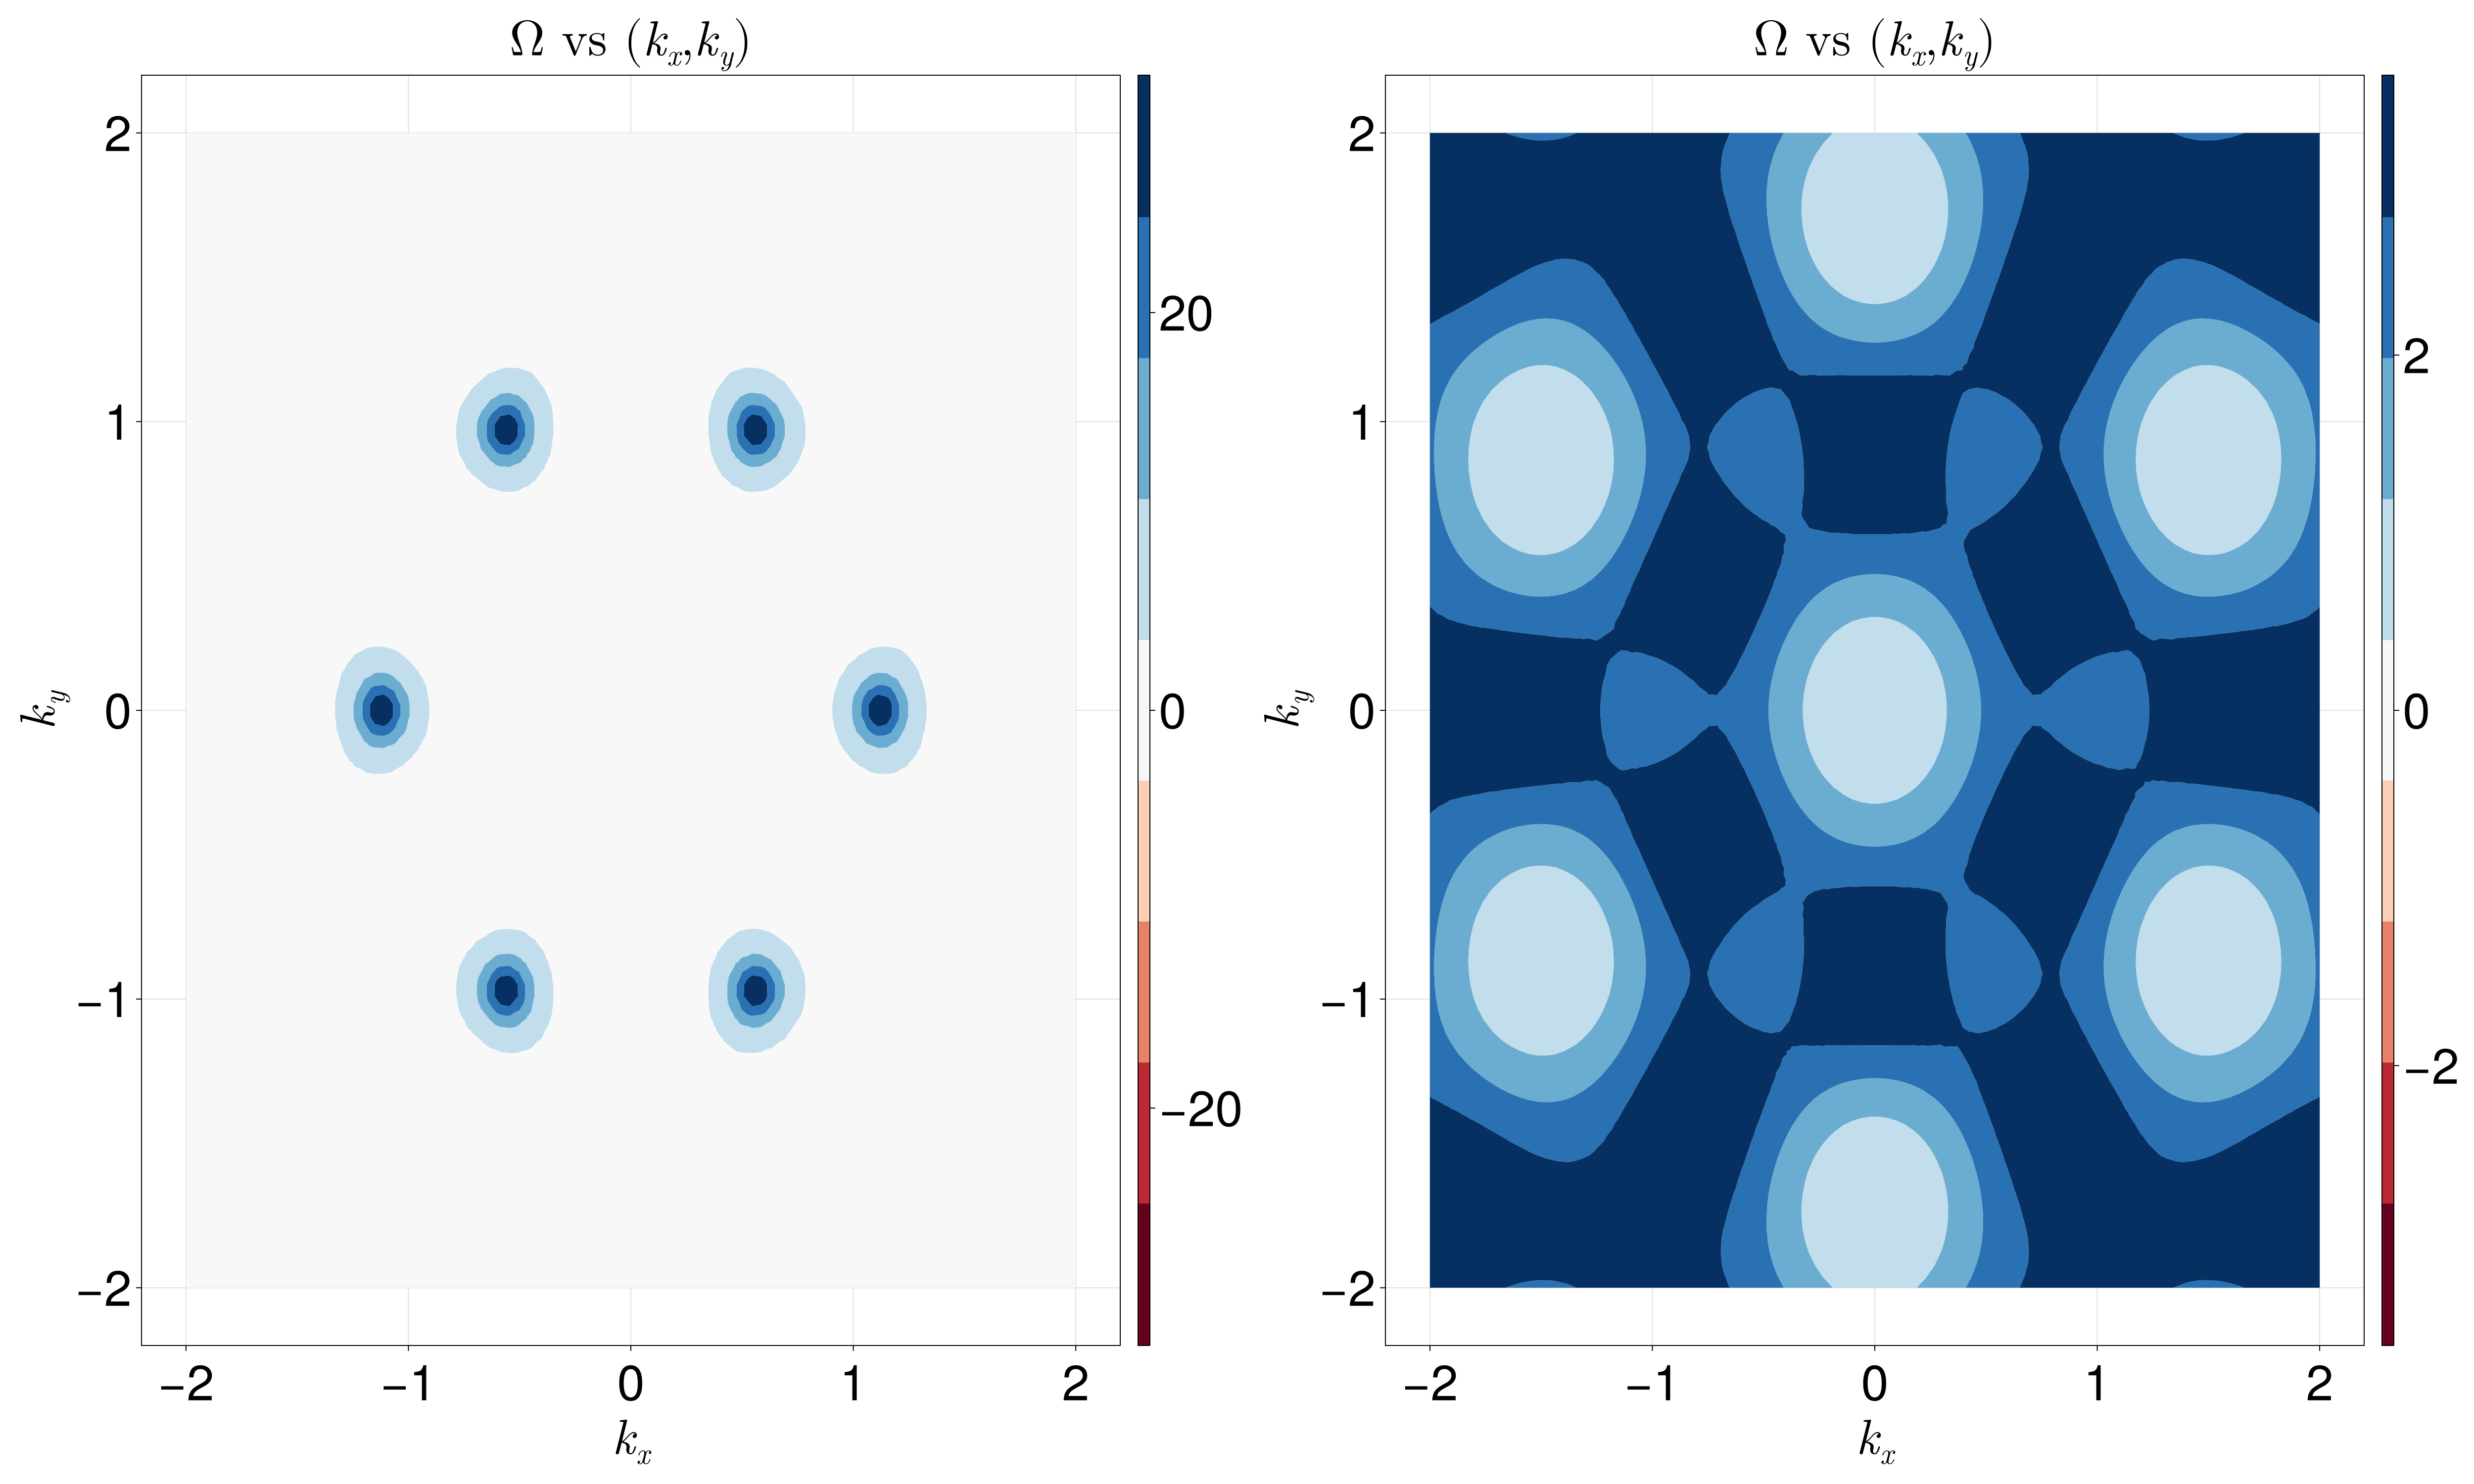

In [939]:
pd = 100
Nl = 3
nu = 0.6
kappa = 1
V = 10
index = 1
shells = 4
mBZ_berry(pd, Nl, nu, kappa, V, shells)

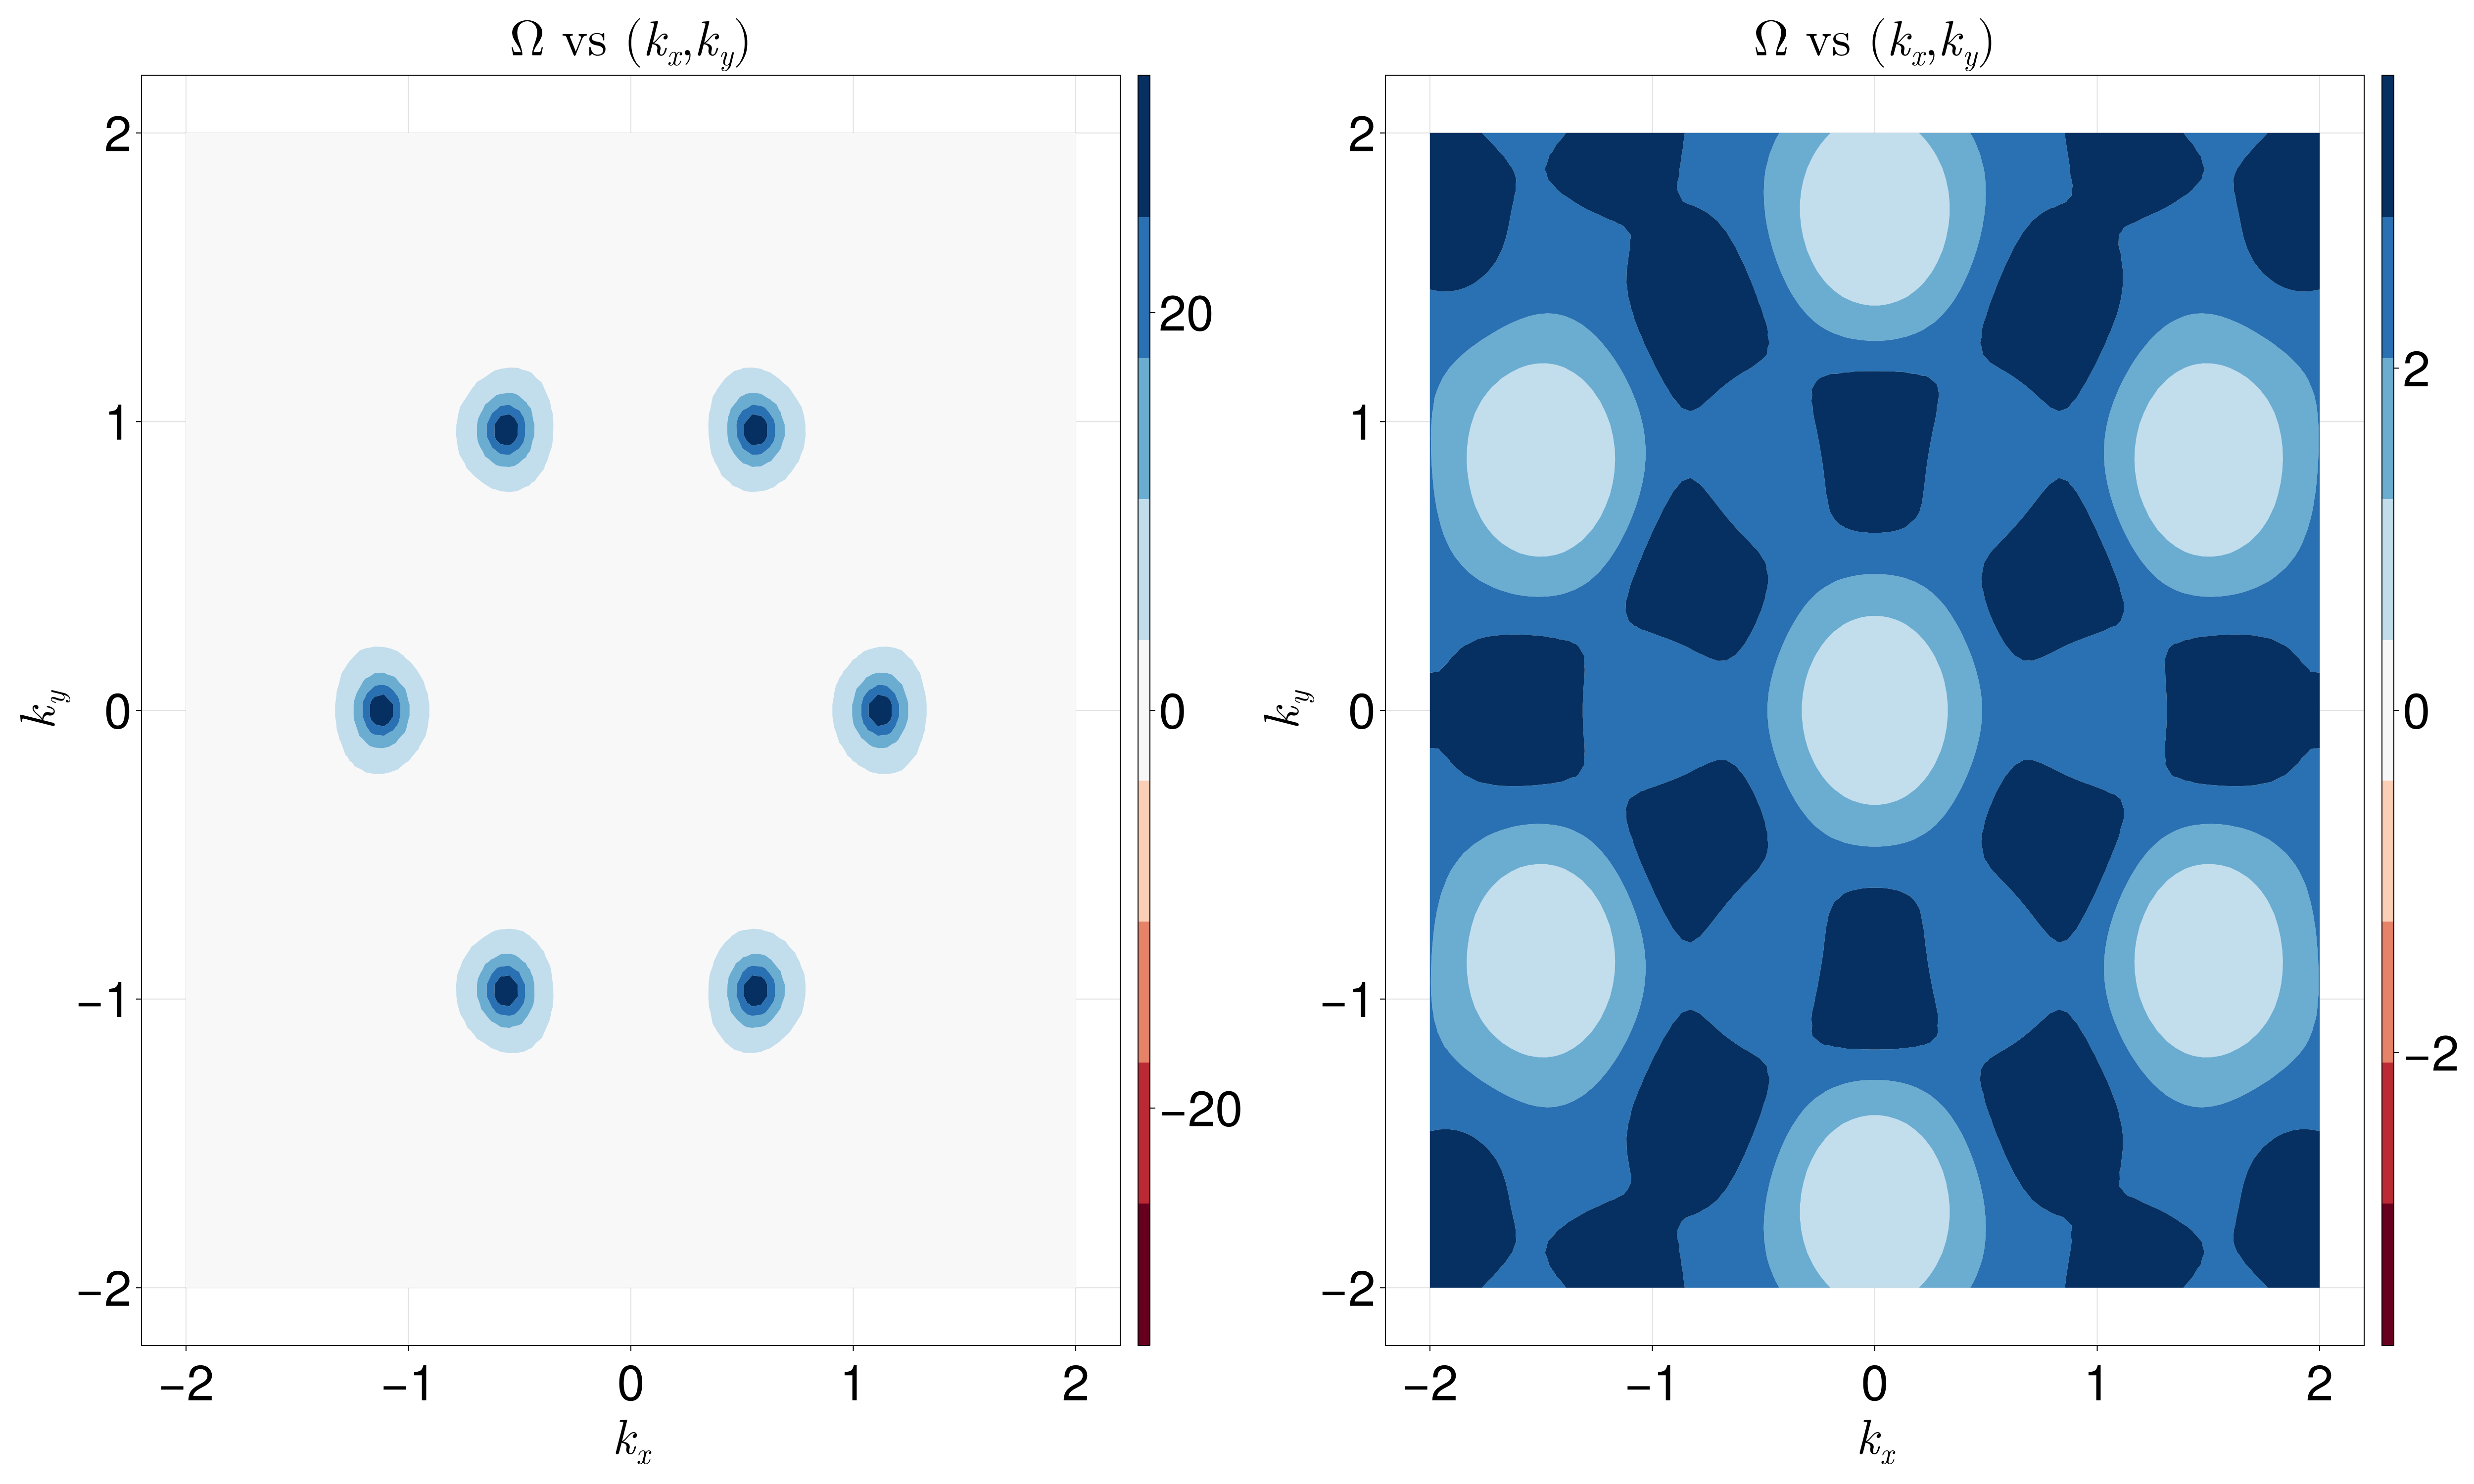

In [936]:
pd = 100
Nl = 3
nu = 0.6
kappa = 1
V = 10
index = 1
shells = 3
mBZ_berry(pd, Nl, nu, kappa, V, shells)

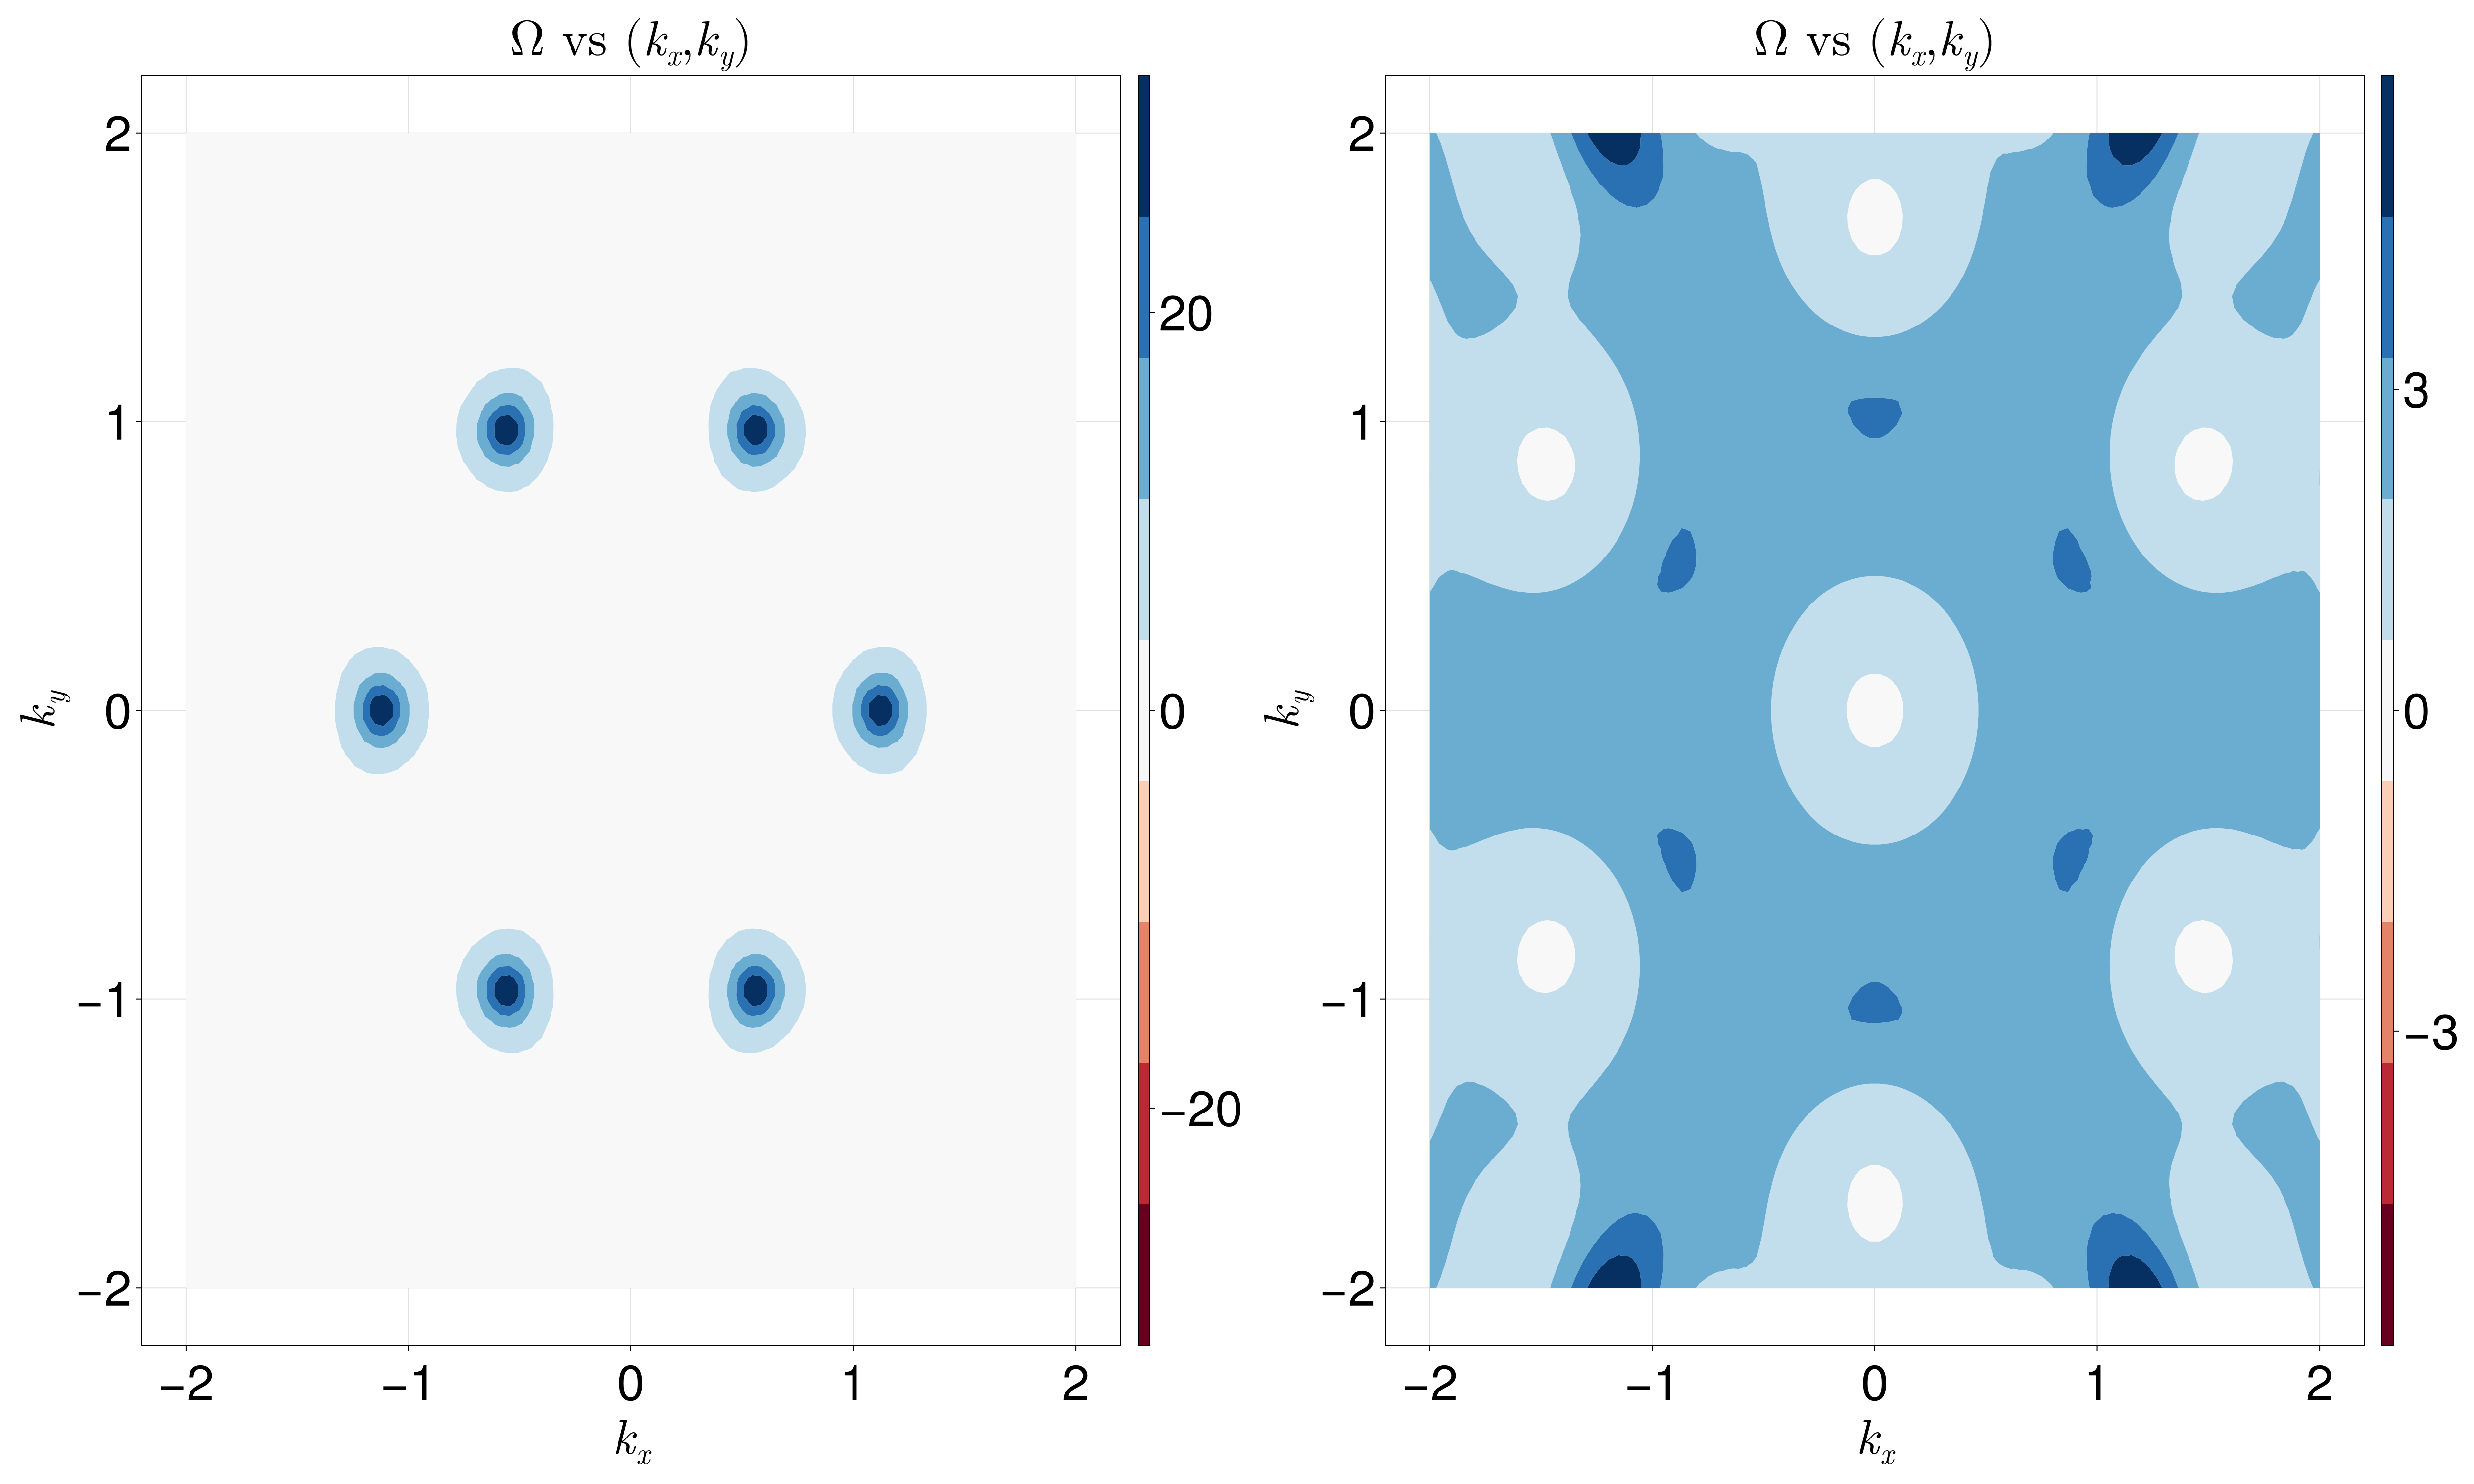

In [938]:
pd = 100
Nl = 3
nu = 0.6
kappa = 1
V = 10
index = 1
shells = 2
mBZ_berry(pd, Nl, nu, kappa, V, shells)

# Optimization

In [24]:
function uniform_chern_v2(Nl, nu, kappa, V, shells, index, spacing)
    num_vertices = 4
    mom_list = partitions_to_momenta(shells, kappa)

    mBZ_count = num_mBZ(shells)
    partitions = sgn_partitions(shells)
    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1), Nl)
    grounds = Array{ComplexF64}(undef, num_vertices, size(mom_list, 1))
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)
    
    points = make_hex([0, 0], kappa, spacing)

    berry = 0

    for i in 1:size(points)[1]
        berry += uniform_mBZ_bc!(g1, g2, gi, gj, num_vertices, plaq_area, mom_list, partitions, ham, spinors, grounds, 
        points[i, :], Nl, nu, kappa, V, shells, index, spacing)
    end
    return 1/(2 * pi) * plaq_area * berry
end

uniform_chern_v2 (generic function with 1 method)

In [59]:
Nl = 3
nu = 0.6
kappa = 1
V = 1
index = 1
shells = 1
spacing = 0.2 * 10^(-2)

0.0020000000000000005

In [60]:
@time uniform_chern_v2(Nl, nu, kappa, V, shells, index, spacing)

113.675780 seconds (1.46 G allocations: 129.741 GiB, 6.05% gc time)


2.0473860078296338